In [1]:
#######
# Starter code for Time Series Analysis and Forecasting
#
# You will need to install the YahooFinance Python api
#
# Using Anaconda environment:
# - conda install -c conda-forge yfinance
#
# Using pip 
# - pip install yfinance
#
# Veryify it is installed by importing it in your Jupyter Notebook.
# If you cannot get it to install, you can always Google Search
# "install yfinance Python library"  and it will give you search results
# that walk you through.   As of 13-Nov-2024 both methods work.
#
# https://stackoverflow.com/questions/39636128/yahoo-finance-package-installation-in-anaconda
###

In [2]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sktime

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [5]:
import datetime 
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import numpy.linalg

import yfinance as yf
import pandas as pd

from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler

from sktime.split import temporal_train_test_split # error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima 



In [6]:
#####
# 40 years of data starting from when Disney got on the market
##
TRADE_START='1962-1-2'
TRADE_END='2002-1-2'

disneyTicker='DIS'

In [7]:
NUM_BINS= 20

In [8]:
disData= yf.download(disneyTicker, start=TRADE_START,end= TRADE_END)

[*********************100%***********************]  1 of 1 completed


In [9]:
disData.head()

Price      Adj Close     Close      High       Low      Open   Volume
Ticker           DIS       DIS       DIS       DIS       DIS      DIS
Date                                                                 
1962-01-02  0.057941  0.092908  0.096026  0.092908  0.092908   841958
1962-01-03  0.058719  0.094155  0.094467  0.092908  0.092908   801865
1962-01-04  0.058719  0.094155  0.094467  0.093532  0.094155   962238
1962-01-05  0.058914  0.094467  0.094779  0.093844  0.094155   962238
1962-01-08  0.058719  0.094155  0.095714  0.092285  0.094467  1282984

In [10]:
######
# To learn more, see multi-level columns in Pandas.
# They are kinda cool and make sense for complex aggregated data.
#
# https://pandas.pydata.org/docs/user_guide/advanced.html
#
# https://stackoverflow.com/questions/63107594/how-to-deal-with-multi-level-column-names-downloaded-with-yfinance
###

df_dis_close = disData['Close']

In [11]:
df_dis_close.describe()

Ticker           DIS
count   10069.000000
mean        7.280632
std        10.349134
min         0.053625
25%         0.745013
50%         1.292212
75%        10.810396
max        43.036064

<AxesSubplot:>

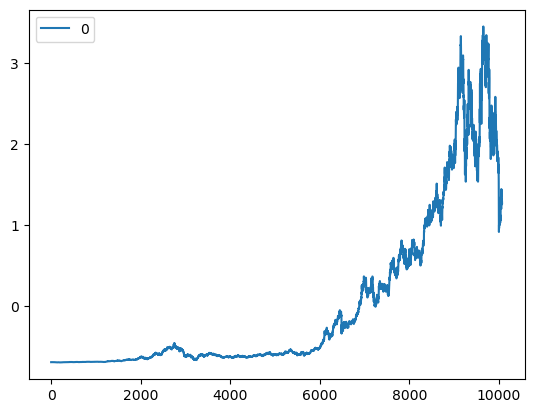

In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_dis_close.values.reshape(-1, 1)) 
scaled_series= pd.DataFrame(scaled_data)
scaled_series.plot()

In [13]:
#####
#  Visualizations of various transformations
###

def visTransformations(df_data, dataName, windowSize):
    plt.figure(1,figsize=(30,90))
    plt.subplot(10,1,1)
    df_data.plot()
    plt.title(f'{dataName} closing price')
    
    plt.subplot(10,1,2)
    plt.title(f'{dataName} filtered outliers')
    z_scores = zscore(df_data)
    abs_z_scores = np.abs(z_scores)
    filtered_data = (abs_z_scores < 2)  # Z-score trheshold two standard deviations
    series_no_outliers = df_data[filtered_data]
    series_no_outliers.plot()

#    plt.subplot(9,1,3)
#    plt.title('{dataName} scaled and filtered')
#    scaler = StandardScaler()
#    scaled_data = scaler.fit_transform(series_no_outliers.values.reshape(-1, 1)) 
#    scaled_series= pd.DataFrame(scaled_data)
#    scaled_series.plot()

    plt.subplot(10,1,3)
    binCountsDIS, binEdgesDIS, patchesDIS= plt.hist(df_data,NUM_BINS)
    plt.title(f'{dataName} stock distribution')
    
    # long vs short term trend depends on window size
    plt.subplot(10,1,4)
    plt.title(f'{dataName} rolling average win=%i' %windowSize )
    df_dis_close.rolling(windowSize).mean().plot()
    
    # std dev over rolling window
    # shows how variance changes over time
    plt.subplot(10,1,5)
    plt.title(f'{dataName} rolling std win=%i'%windowSize)
    df_data.rolling(windowSize).std().plot()
    
    # can think of it like the local slope
    plt.subplot(10,1,6)
    plt.title(f'{dataName} difference 1x')
    df_data.diff().plot()

    DIFF_ORDER= 10
    plt.subplot(10,1,7)
    plt.title(f'{dataName} difference {DIFF_ORDER}x')
    df_diff= df_data
    for i in range(DIFF_ORDER):
        df_diff= df_diff.diff()
        
    df_diff.plot()

    # computes rolling window mean over difference
    # can i really remove the trend?
    plt.subplot(10,1,8)
    plt.title(f'{dataName} mean diff win=%i' %windowSize)
    df_data.diff().rolling(windowSize).mean().plot()
    
    plt.subplot(10,1,9)
    plt.title(f'{dataName} std diff win=%i' %windowSize)
    df_data.diff().rolling(windowSize).std().plot()

    # standard scaler 
    plt.subplot(10,1,10)
    plt.title(f'{dataName} scaled and filtered')
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(series_no_outliers.values.reshape(-1, 1)) 
    plt.plot(scaled_data)

In [14]:
##############
# Augmented Dickey-Fuller Test
#
# Ho: It is non-stationary
# H1: It is stationary
#
#####

def adfuller_test(sales):
    result=adfuller(sales)
    print(result)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

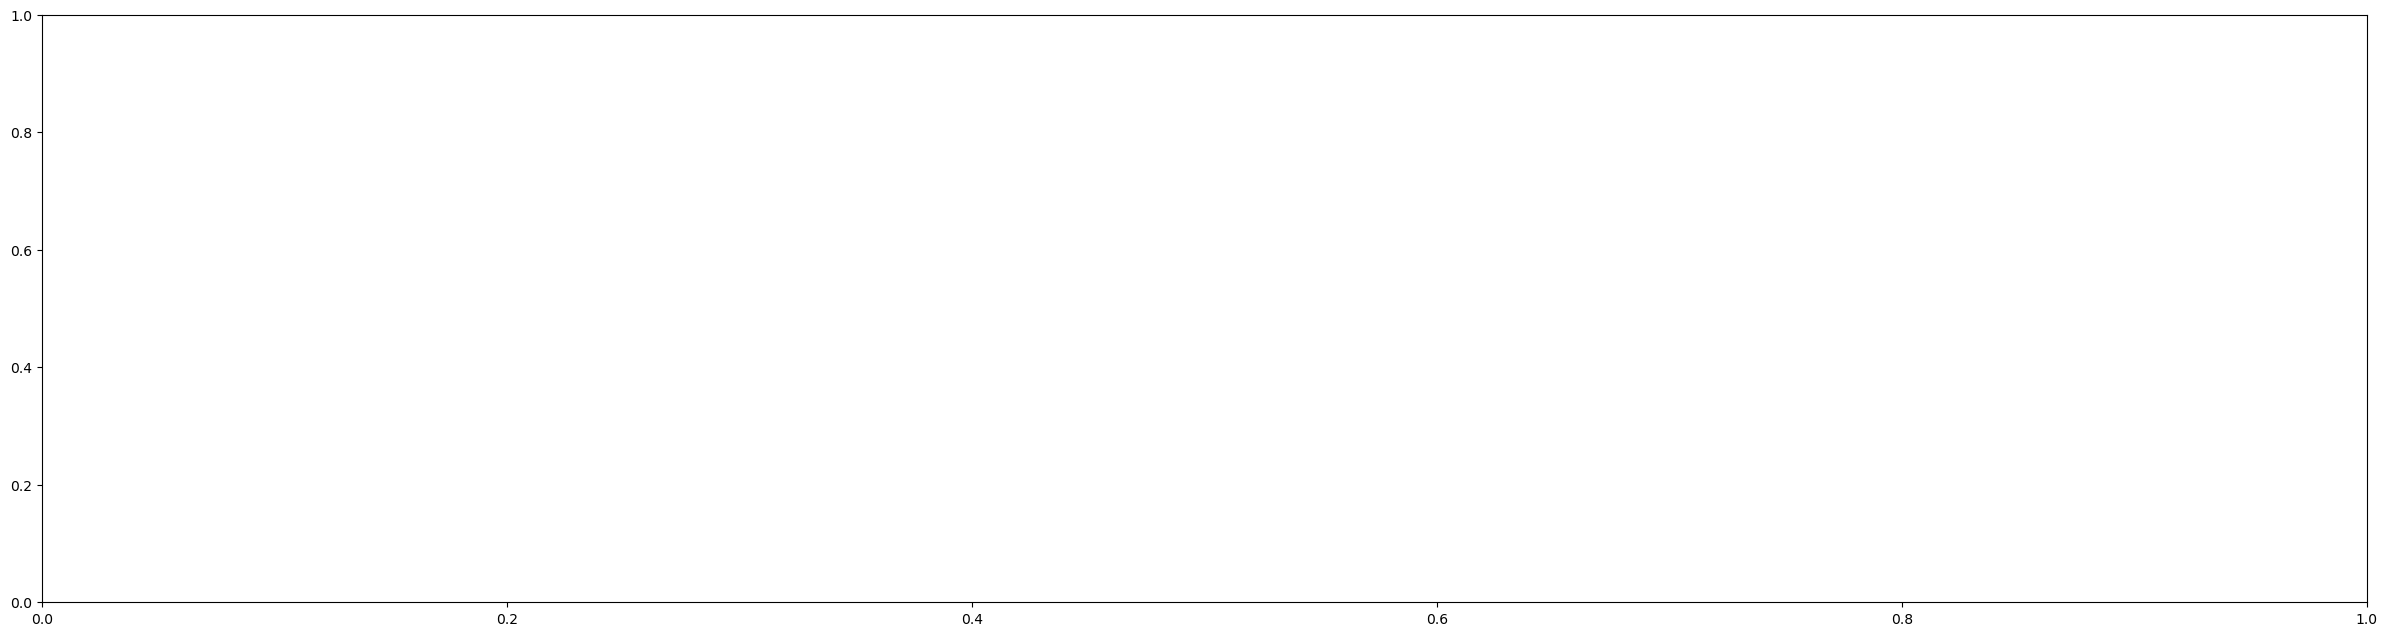

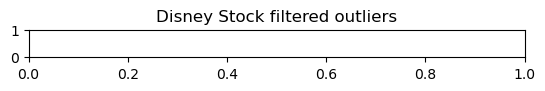

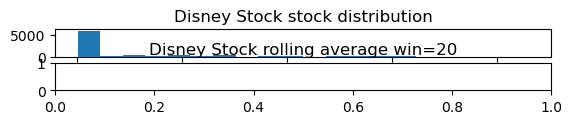

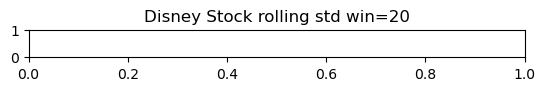

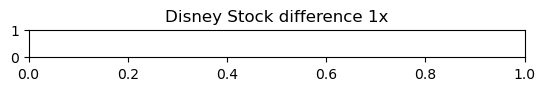

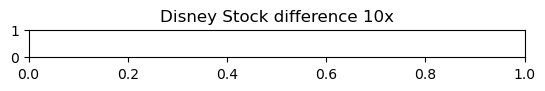

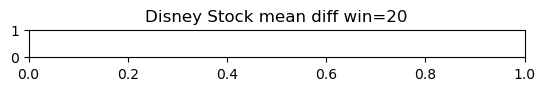

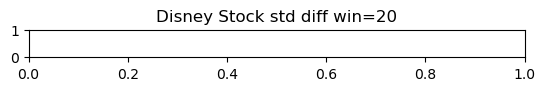

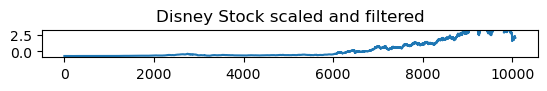

In [15]:
visTransformations(df_dis_close,'Disney Stock',20)

In [16]:
# visualizations for entire data set (without specifying periods)
def vis(df_data, dataName, windowSize):
    plt.figure(7,figsize=(20,50))
    
    plt.subplot(7, 1, 1)
    df_data.plot()
    plt.title(f'{dataName} closing price')
    
    plt.subplot(7, 1, 2)
    plt.title(f'{dataName} simple moving average')
    df_dis_close.rolling(windowSize).mean().plot(use_index=True, color='r')
    
    plt.subplot(7, 1, 3)
    plt.title(f'{dataName} rolling std win=%i'%windowSize)
    df_dis_close.rolling(windowSize).std().plot(use_index=True, color='r')
    
    plt.subplot(7, 1, 4)
    plt.title(f'{dataName} exponential weighted moving average')
    df_dis_close.ewm(windowSize).mean().plot(use_index=True, color='g')
    
    plt.subplot(7, 1, 5)
    plt.title(f'{dataName} EWM std win=%i'%windowSize)
    df_dis_close.ewm(windowSize).std().plot(use_index=True, color='g')
    
    plt.subplot(7, 1, 6)
    plt.title(f'{dataName} closing price and averages compared')
    df_data.plot()
    df_dis_close.rolling(windowSize).mean().plot(use_index=True, color='r')  
    df_dis_close.ewm(windowSize).mean().plot(use_index=True, color='g')
    
    plt.subplot(7, 1, 7)
    plt.title(f'{dataName} rolling and exponential weighted moving std compared')
    df_dis_close.rolling(windowSize).std().plot(use_index=True, color='r')
    df_dis_close.ewm(windowSize).std().plot(use_index=True, color='g')

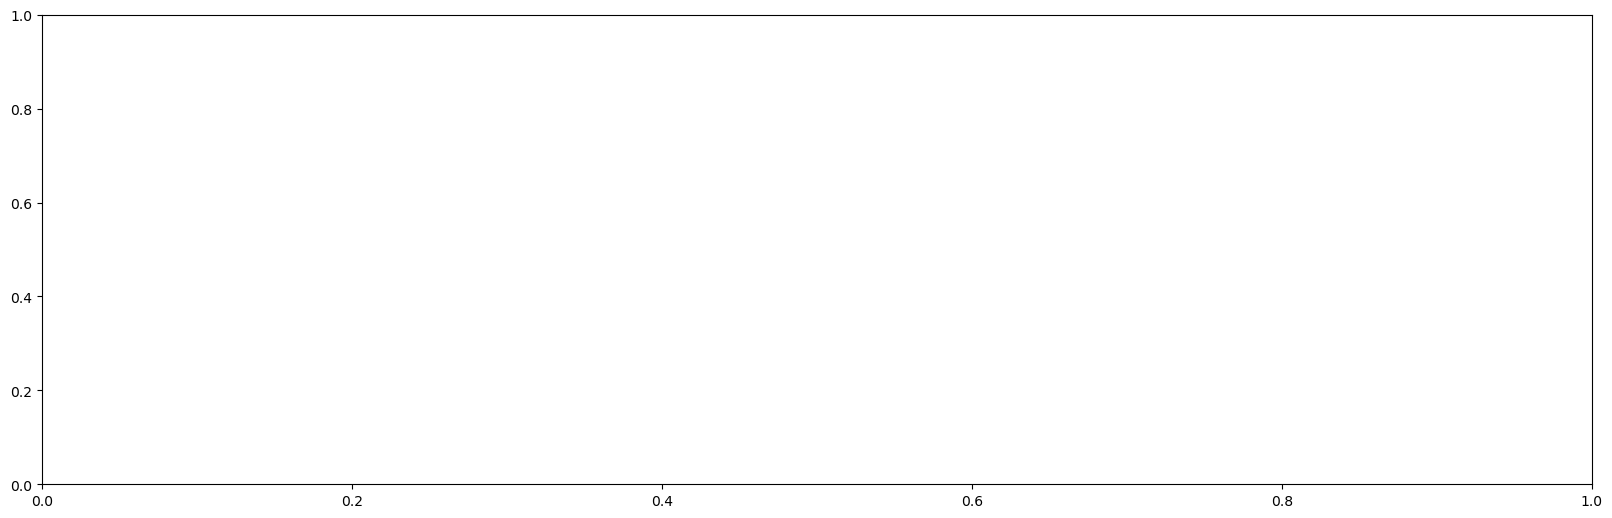

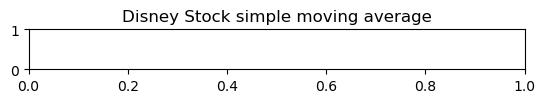

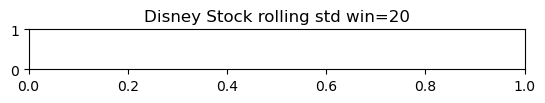

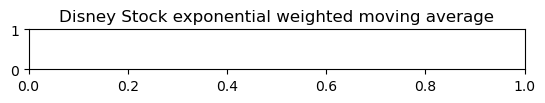

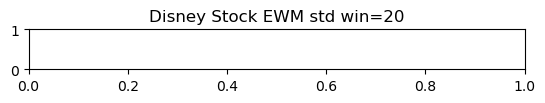

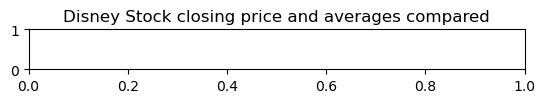

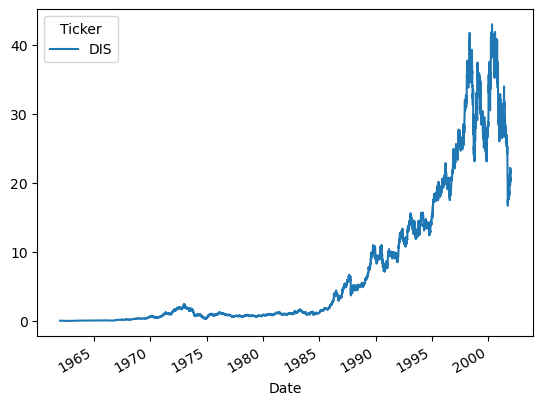

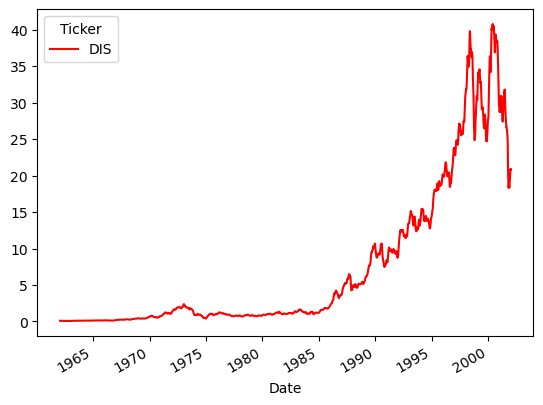

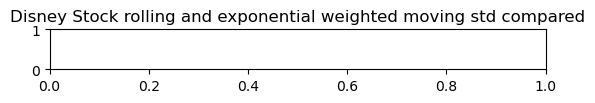

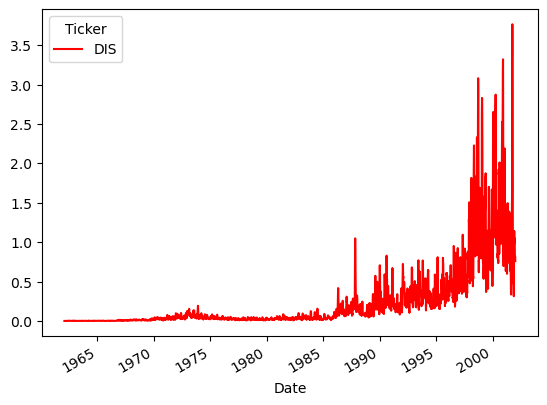

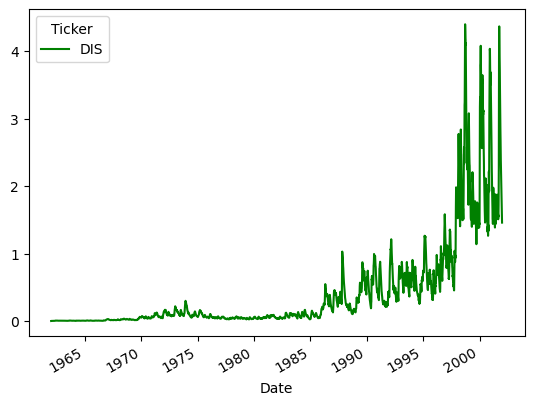

In [17]:
# avg number of trading days in a month is 21, so this represents a month of stock trading data
# SMA and EWMA very reflective of the data set, and their variances have a decent amount of overlap
# seems to be a good short term window size
vis(df_dis_close,'Disney Stock',20)

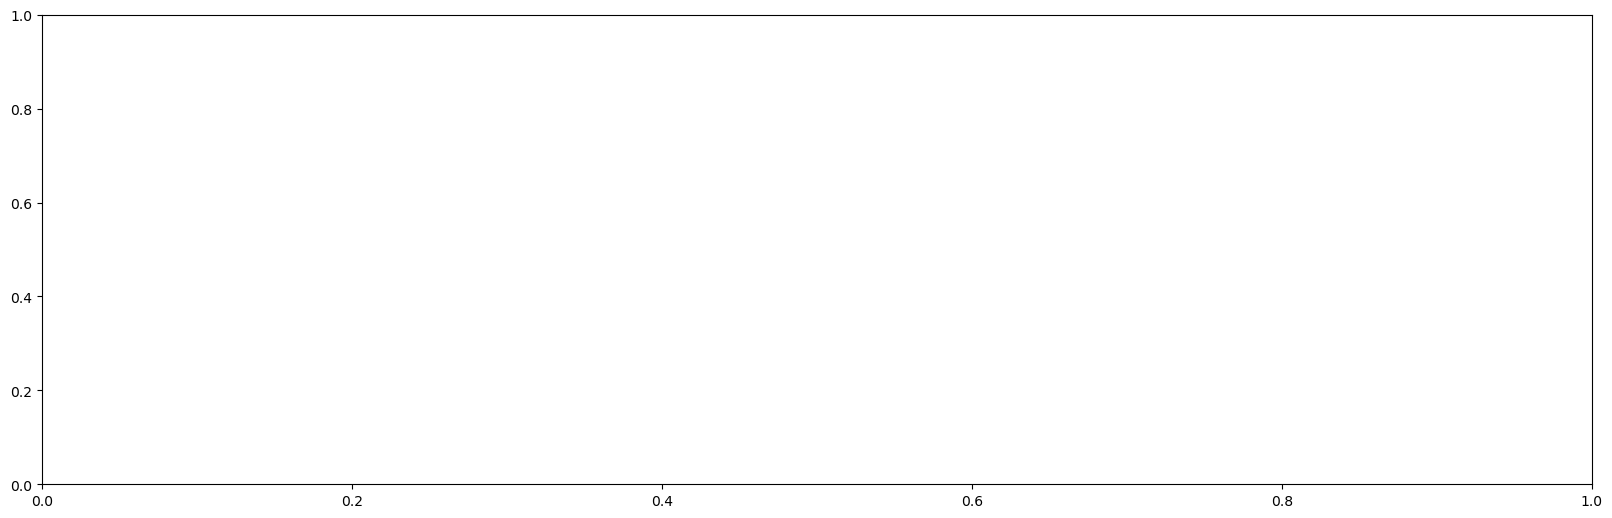

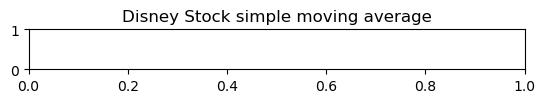

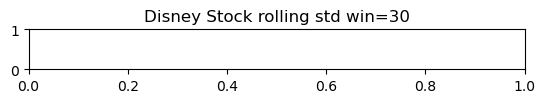

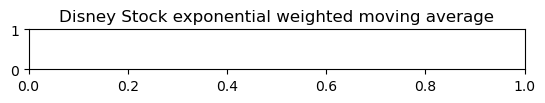

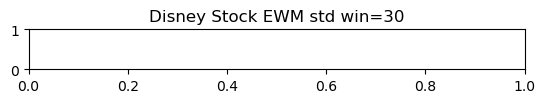

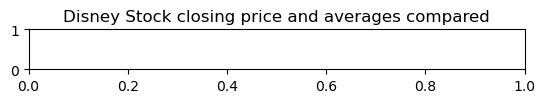

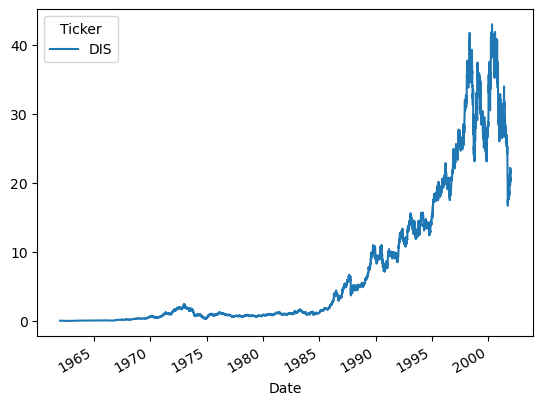

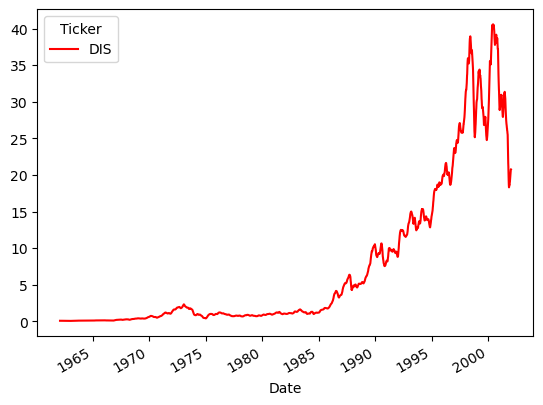

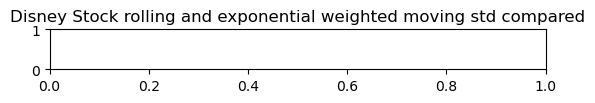

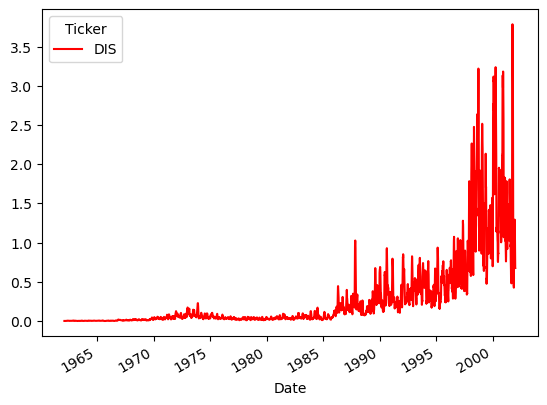

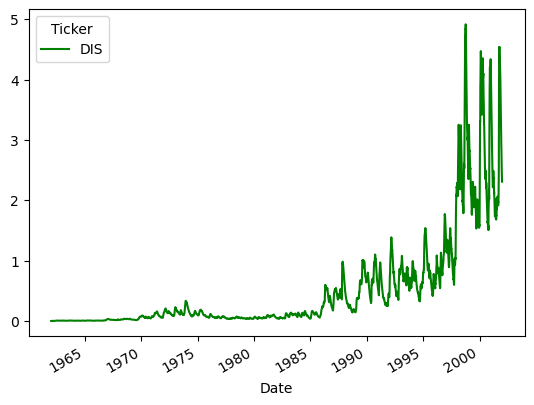

In [18]:
# avg number of trading days in a month is 21, so this gives us about a month and a half window
# SMA and EWMA very similar for this window size and reflective of the overall data set
# ^^ same with their variances
# a decent window size but 20 day window size seems more reflective of original data set
vis(df_dis_close,'Disney Stock',30)

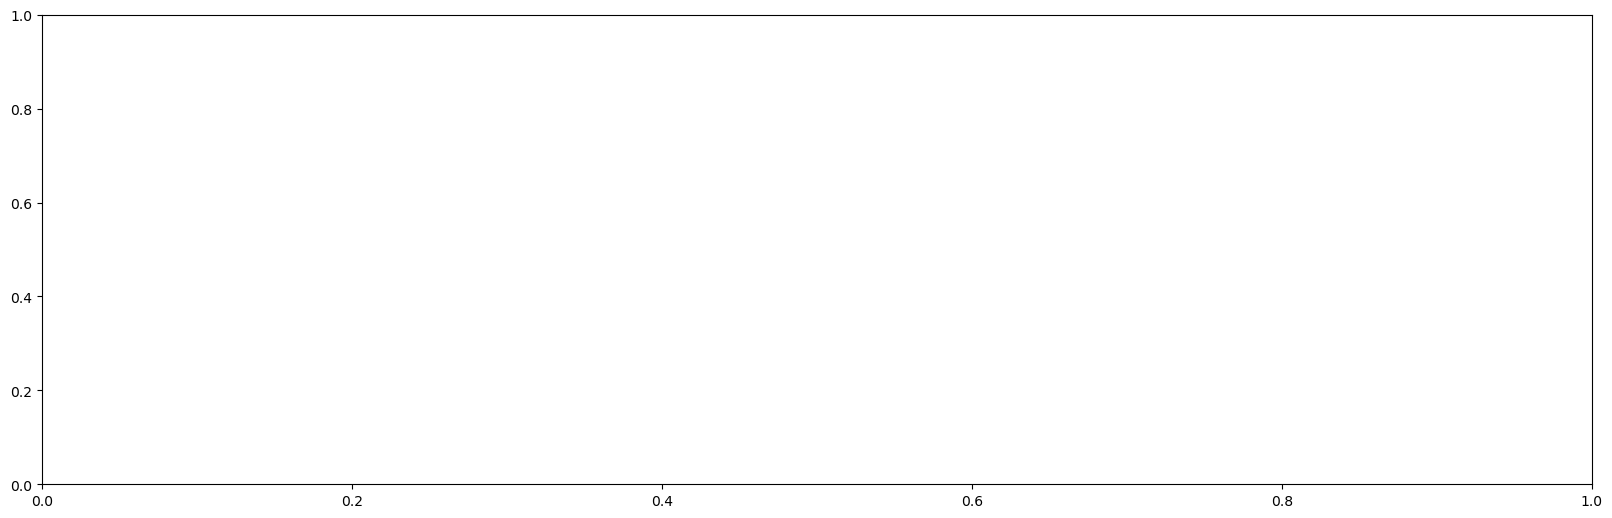

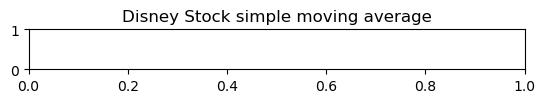

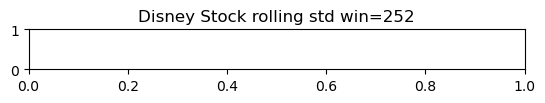

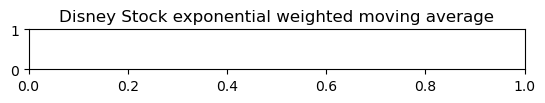

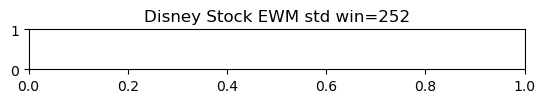

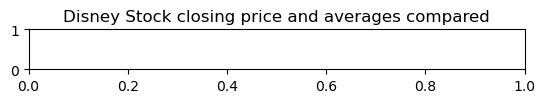

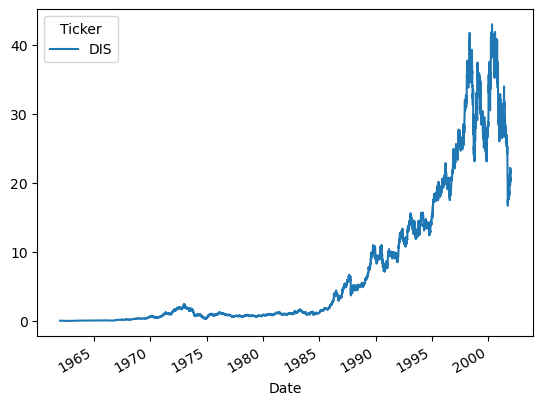

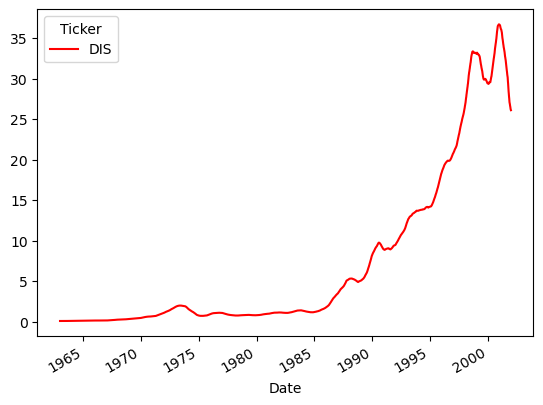

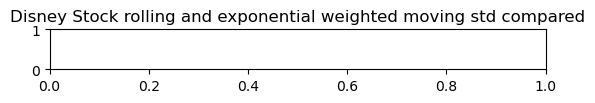

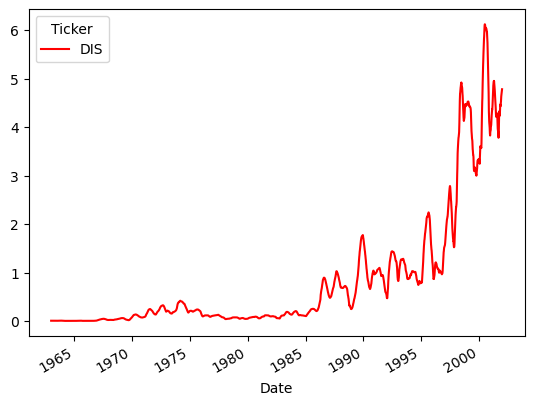

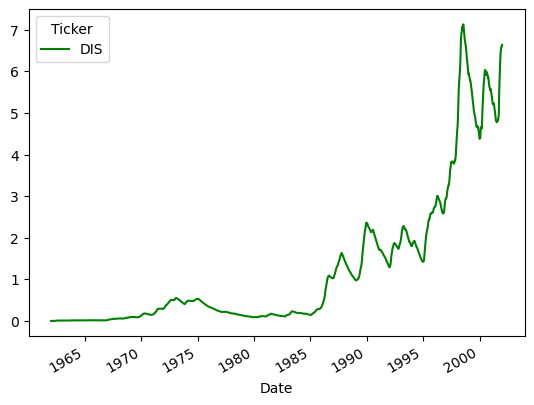

In [19]:
# the number of trading days in a year is 252, so this window represents a year of stock data
# variance of SMA and EWMA not as close but SMA and EWMA values still very similar

vis(df_dis_close,'Disney Stock', 252)

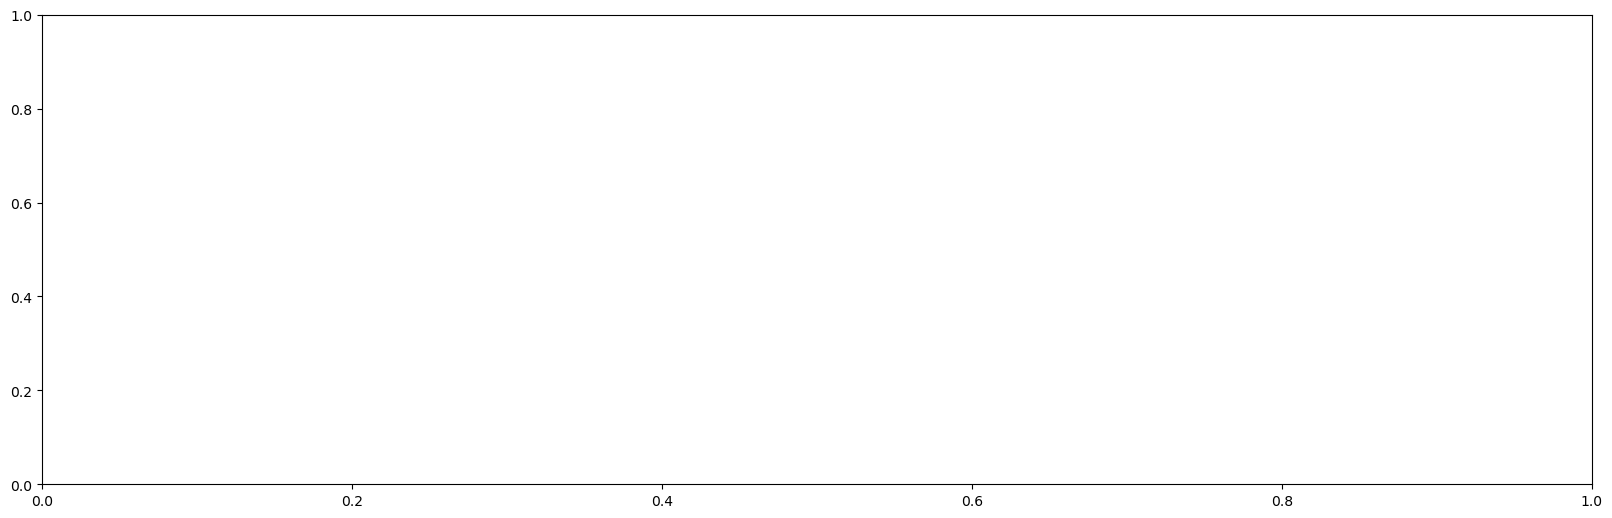

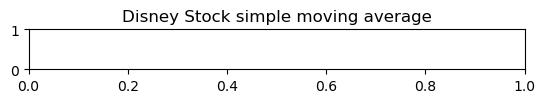

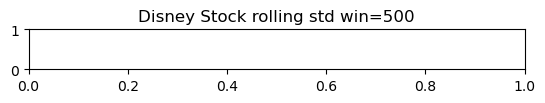

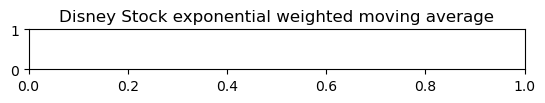

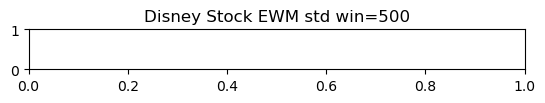

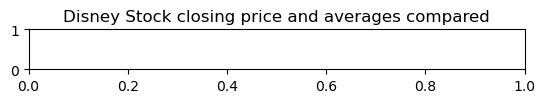

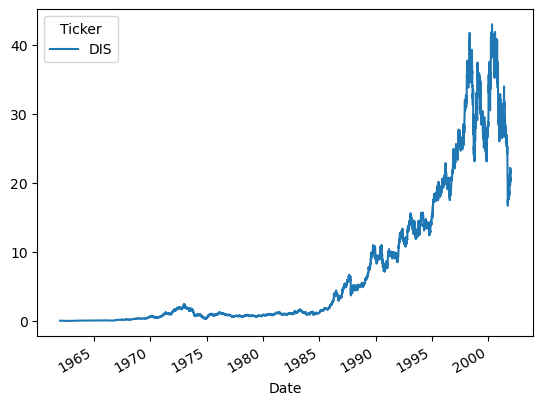

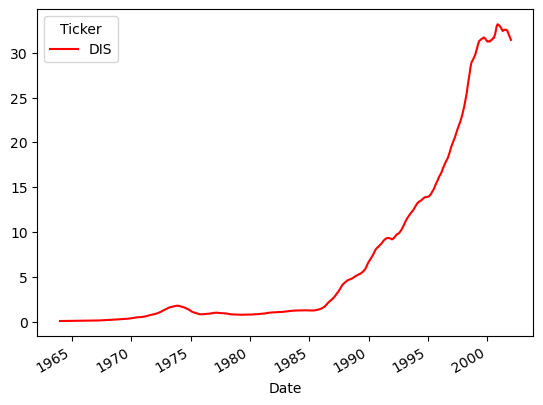

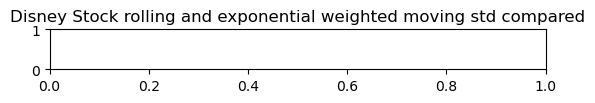

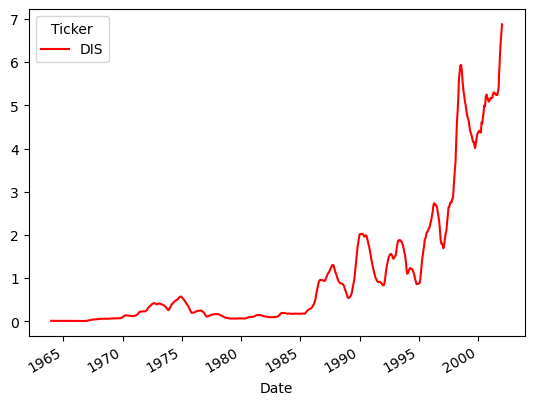

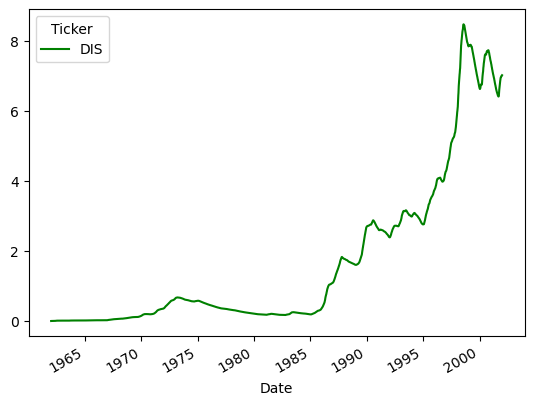

In [20]:
# 504 trading days in 2 years, so 500 roughly represents 2 years of stock data
# not as much overlap with SMA and EWMA compared to 2 year window
# larger gap between variance of SMA and EWMA compared to 1 year window
vis(df_dis_close,'Disney Stock', 500)

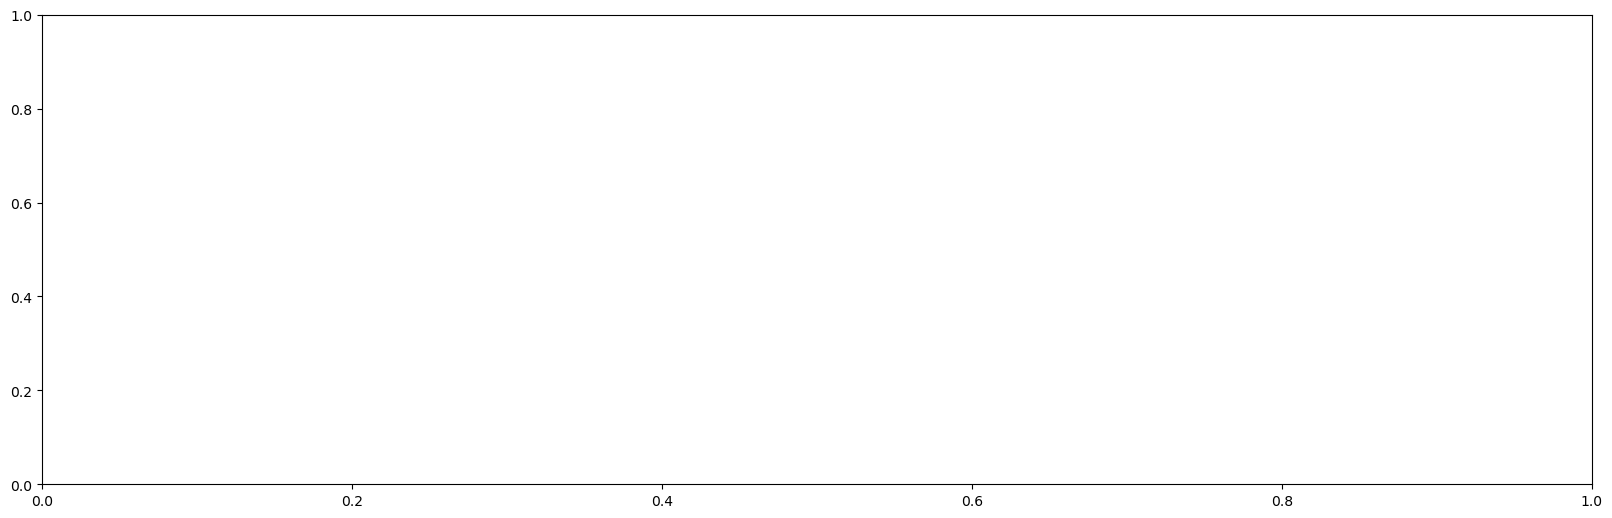

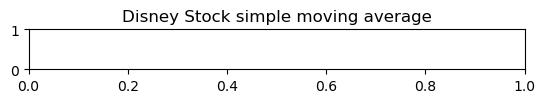

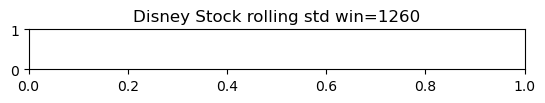

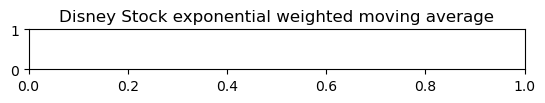

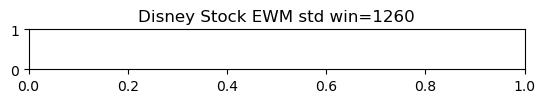

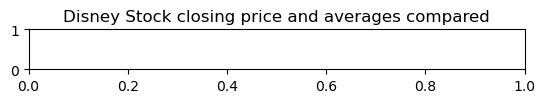

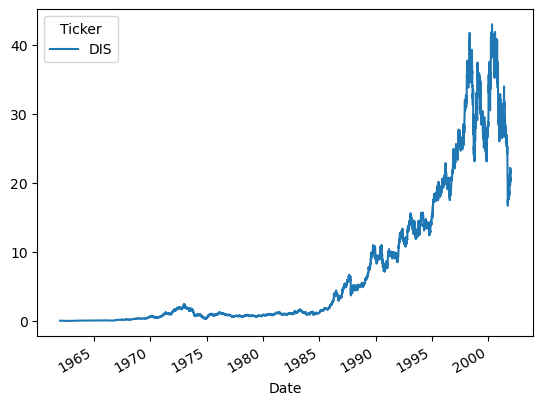

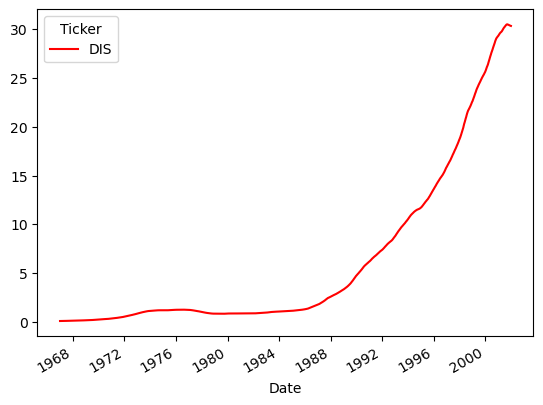

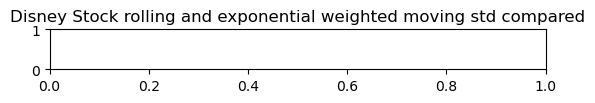

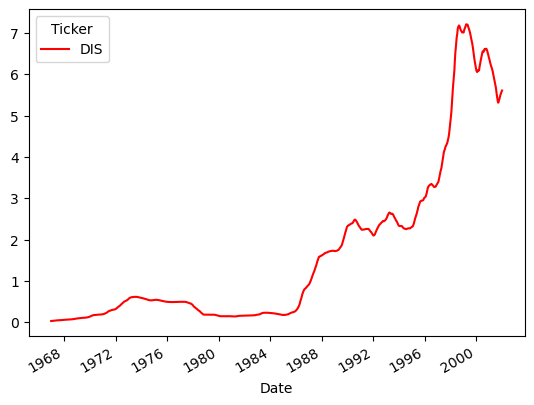

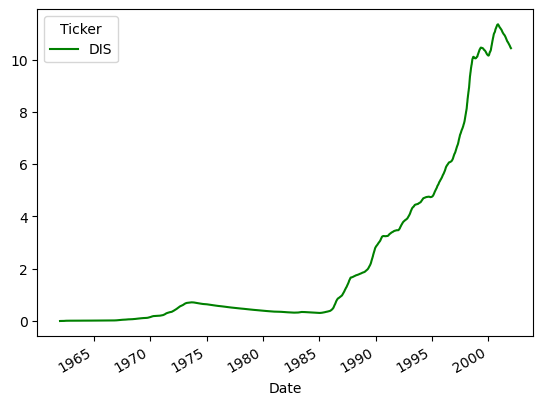

In [21]:
# 1260 represents 5 years of trading days, since our shortest business cycle period is 5 years
# SMA and EWMA very smooth compared to smaller windows
# much larger gap between SMA and EWMA compared to smaller windows, and same with their variances
vis(df_dis_close,'Disney Stock', 1260)

In [22]:
# period dates
# TRADE_START='1962-1-2'
startup_end='1970-1-2'
growth_end='1975-1-2'
maturity_end='1989-1-2'
# TRADE_END='2002-1-2'

# period data
startup= yf.download(disneyTicker, start=TRADE_START,end= startup_end)
growth= yf.download(disneyTicker, start=startup_end,end= growth_end)
maturity= yf.download(disneyTicker, start=growth_end,end= maturity_end)
renewal= yf.download(disneyTicker, start=maturity_end,end= TRADE_END)
# disData= yf.download(disneyTicker, start=TRADE_START,end= TRADE_END)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [23]:
# period closing prices
startup_close= startup['Close']
growth_close= growth['Close']
maturity_close= maturity['Close']
renewal_close= renewal['Close']

<AxesSubplot:xlabel='Date'>

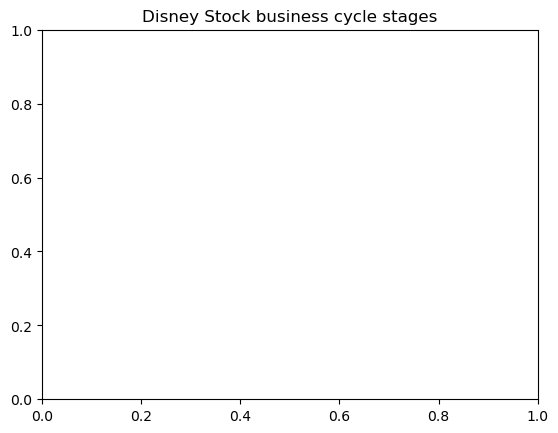

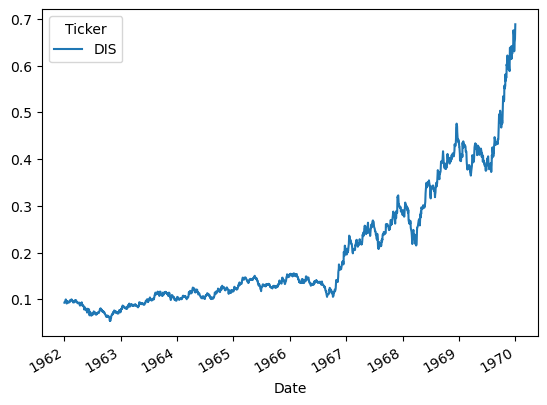

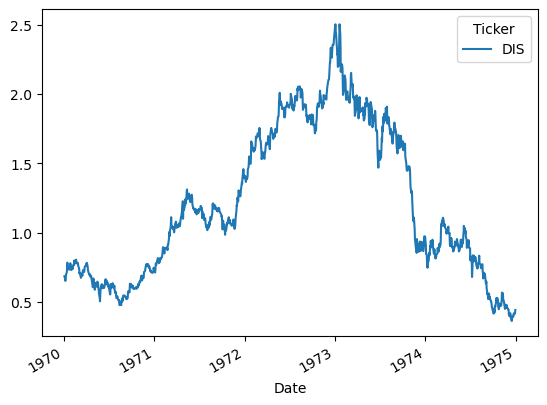

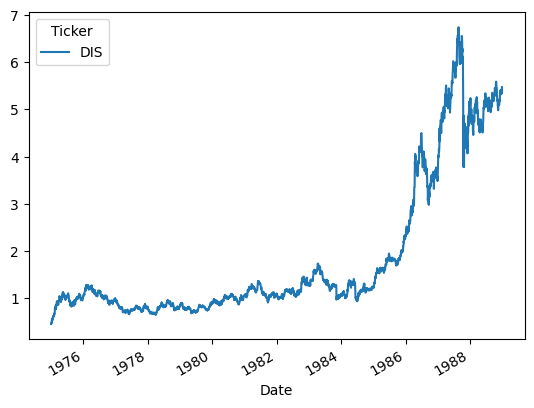

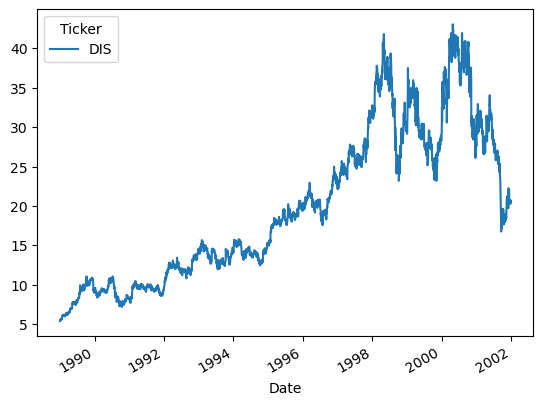

In [24]:
# graph shows stock data for each period of the business cycle
plt.figure(2)
plt.title(f'Disney Stock business cycle stages')
startup_close.plot()
growth_close.plot()
maturity_close.plot()
renewal_close.plot()

In [25]:
def visPeriods(df_start, df_grow, df_mat, df_renew, dataName, windowSize):
    plt.figure(7,figsize=(20,50))
    
    plt.subplot(7, 1, 1)
    df_start.plot()
    df_grow.plot()
    df_mat.plot()
    df_renew.plot()
    plt.title(f'{dataName} closing price')
    
    plt.subplot(7, 1, 2)
    plt.title(f'{dataName} simple moving average')
    df_start.rolling(windowSize).mean().plot(use_index=True)
    df_grow.rolling(windowSize).mean().plot(use_index=True)
    df_mat.rolling(windowSize).mean().plot(use_index=True)
    df_renew.rolling(windowSize).mean().plot(use_index=True)
    
    plt.subplot(7, 1, 3)
    plt.title(f'{dataName} rolling std win=%i'%windowSize)
    df_start.rolling(windowSize).std().plot(use_index=True)
    df_grow.rolling(windowSize).std().plot(use_index=True)
    df_mat.rolling(windowSize).std().plot(use_index=True)
    df_renew.rolling(windowSize).std().plot(use_index=True)
    
    plt.subplot(7, 1, 4)
    plt.title(f'{dataName} exponential weighted moving average')
    df_start.ewm(windowSize).mean().plot(use_index=True)
    df_grow.ewm(windowSize).mean().plot(use_index=True)
    df_mat.ewm(windowSize).mean().plot(use_index=True)
    df_renew.ewm(windowSize).mean().plot(use_index=True)
    
    plt.subplot(7, 1, 5)
    plt.title(f'{dataName} EWM std win=%i'%windowSize)
    df_start.ewm(windowSize).std().plot(use_index=True)
    df_grow.ewm(windowSize).std().plot(use_index=True)
    df_mat.ewm(windowSize).std().plot(use_index=True)
    df_renew.ewm(windowSize).std().plot(use_index=True)

C:\Users\Audrey\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


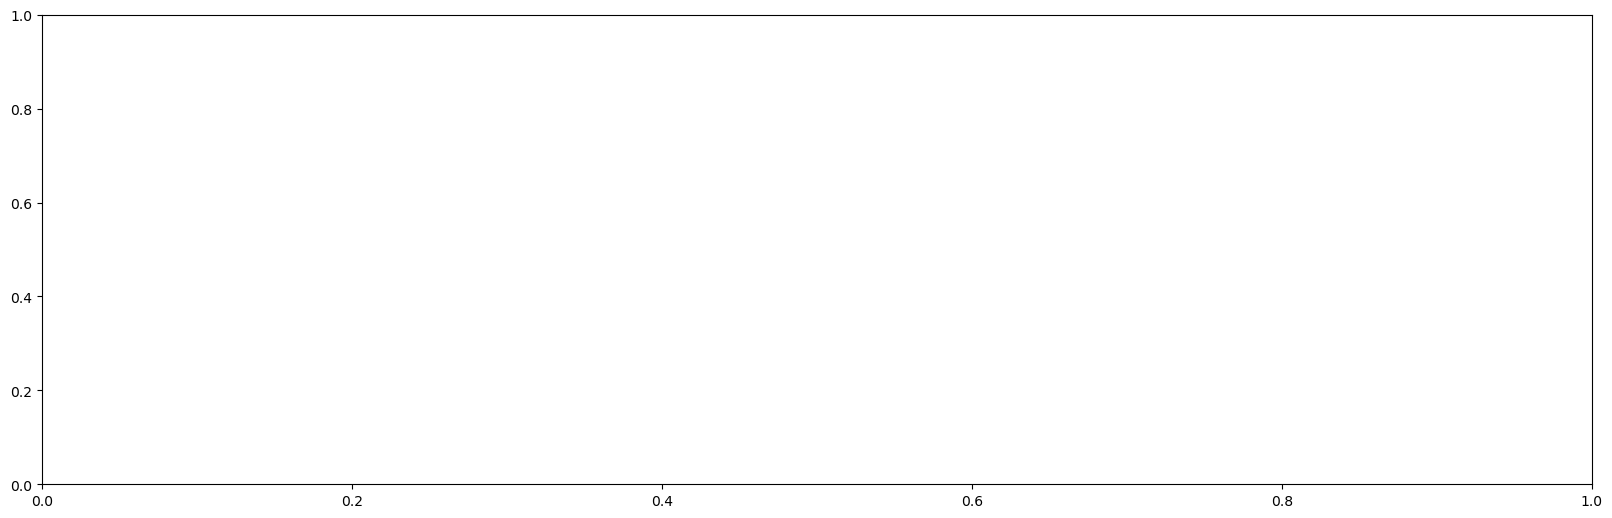

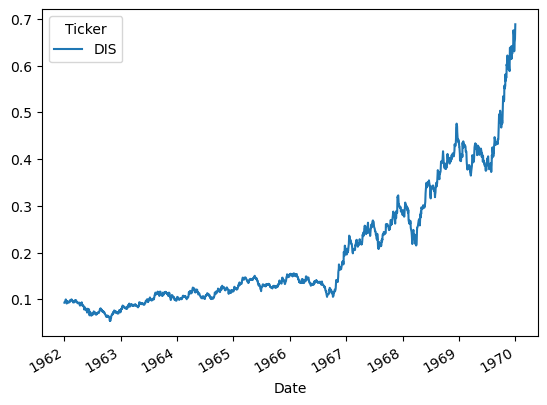

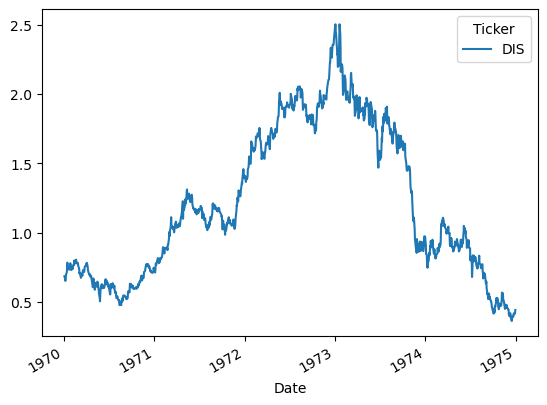

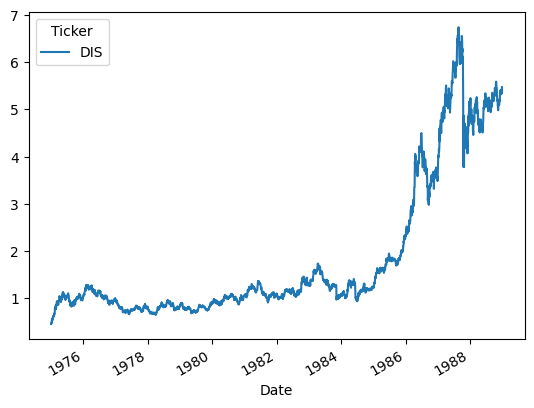

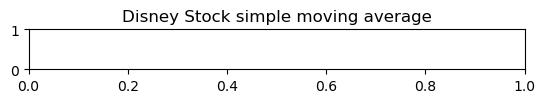

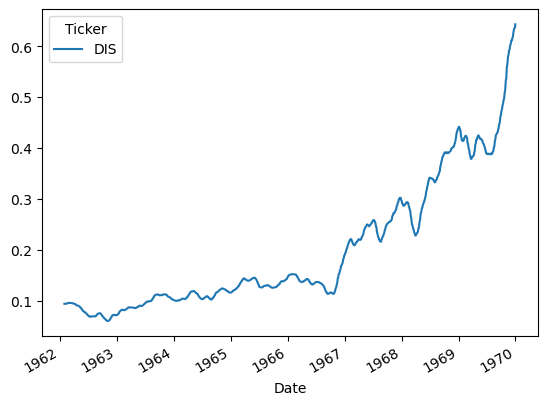

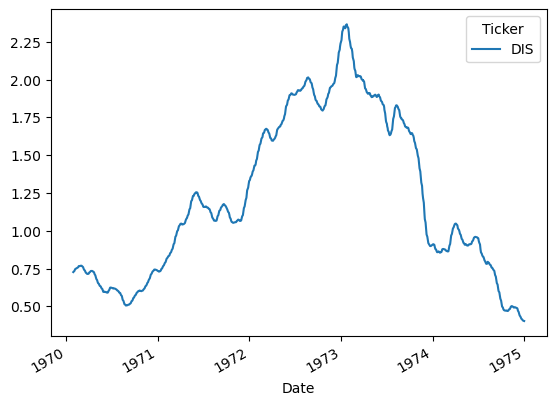

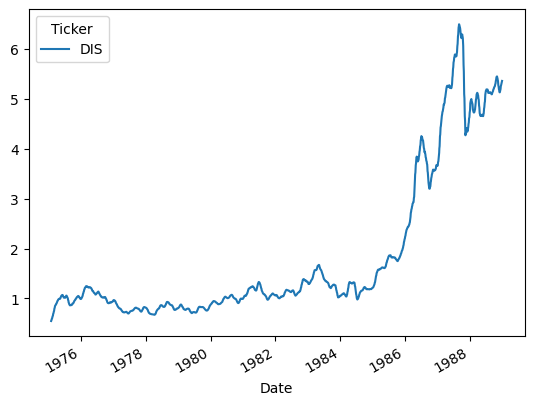

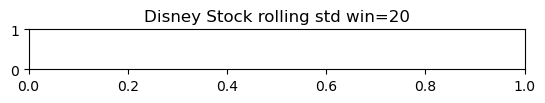

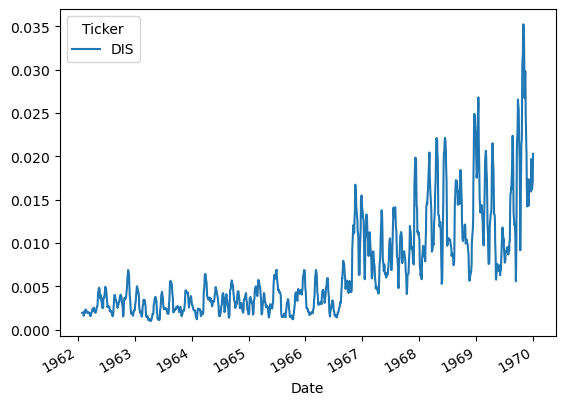

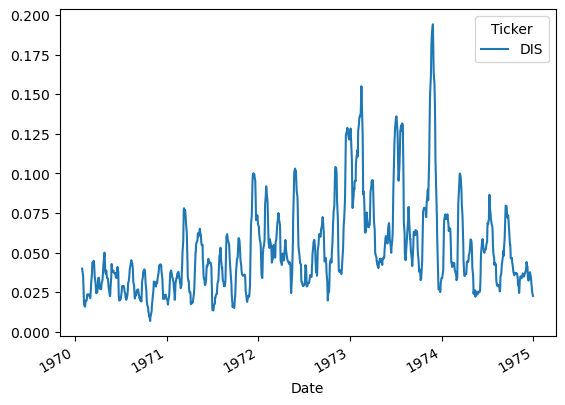

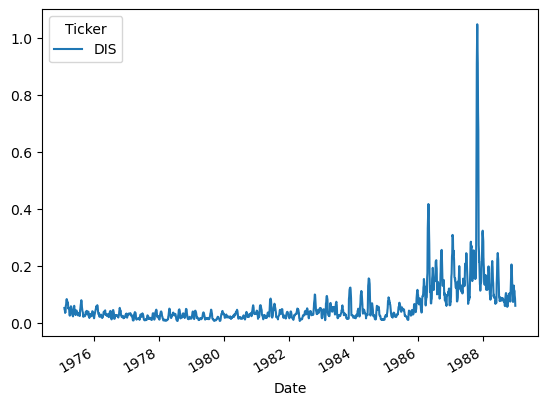

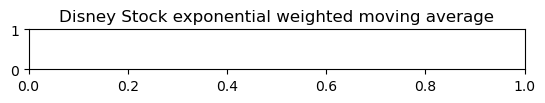

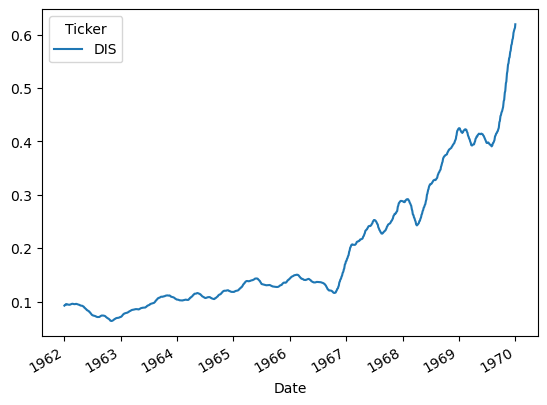

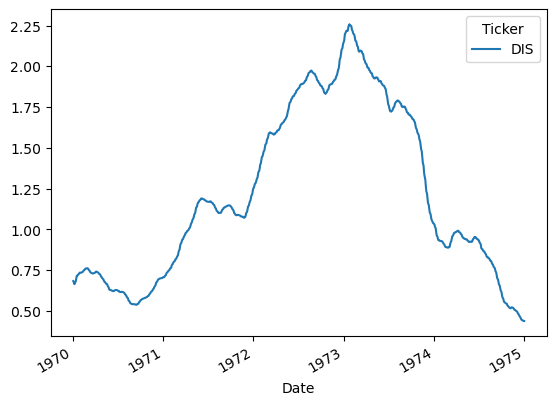

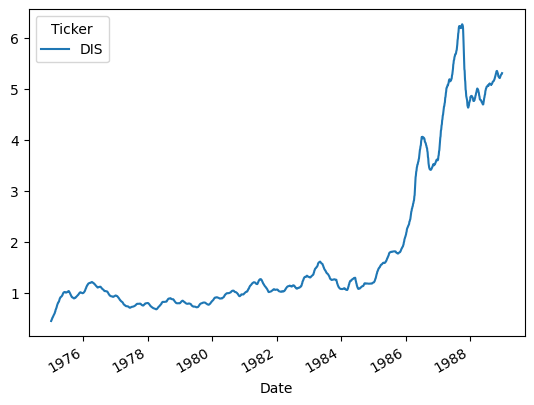

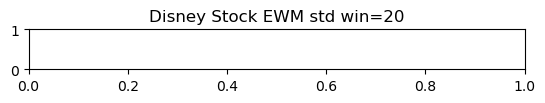

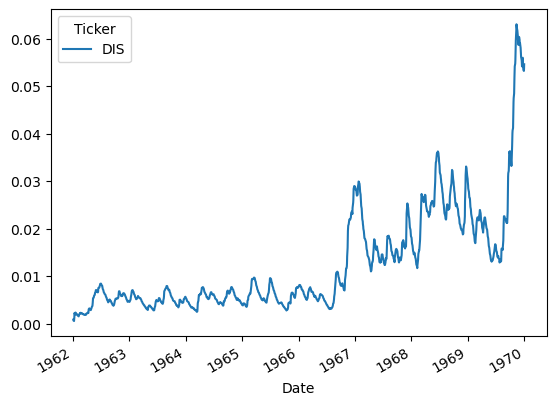

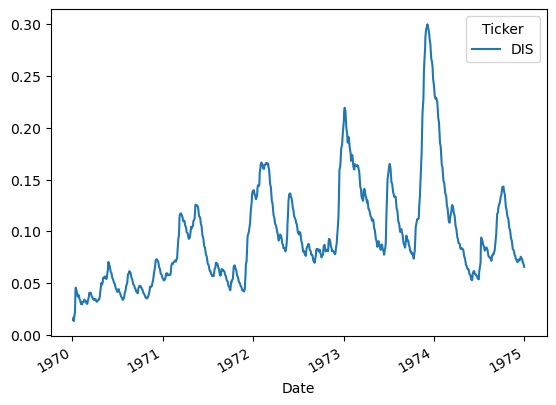

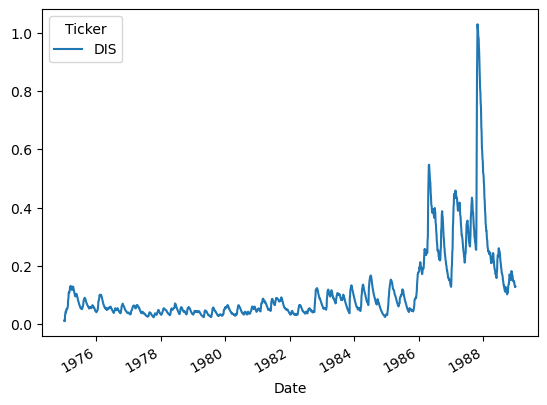

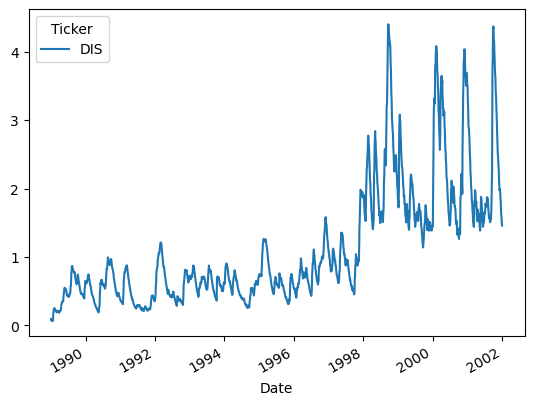

In [26]:
# all visualizations are very similar to those with the 20 day window for the entire data set
visPeriods(startup_close, growth_close, maturity_close, renewal_close, 'Disney Stock', 20)

C:\Users\Audrey\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


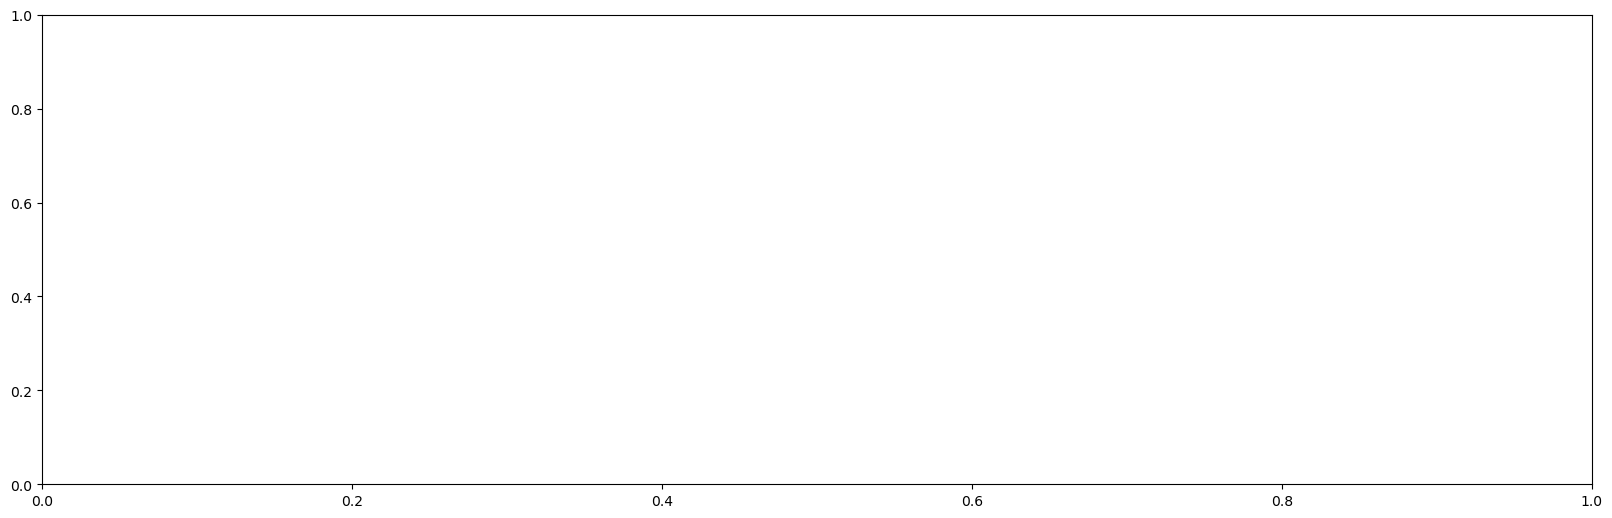

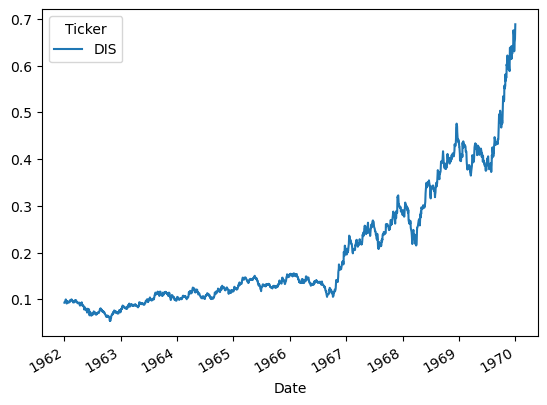

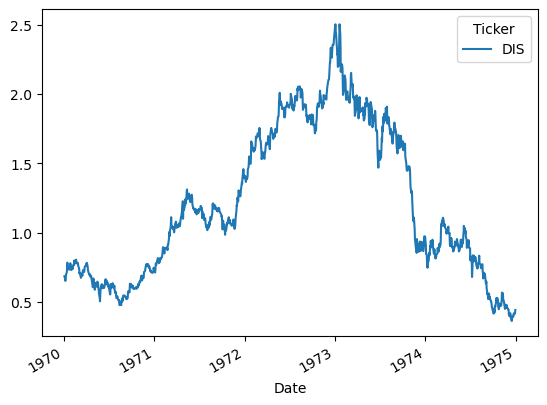

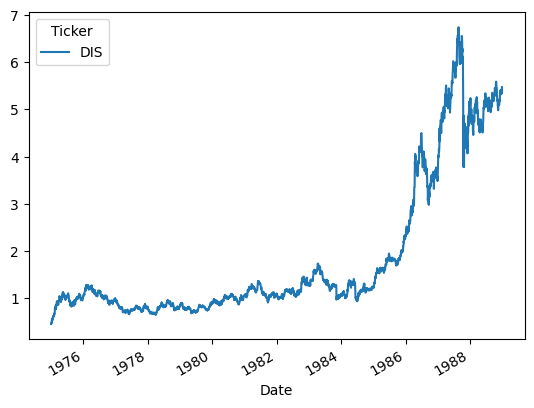

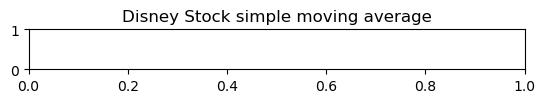

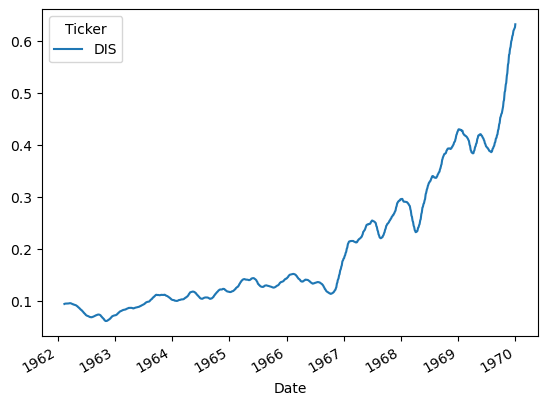

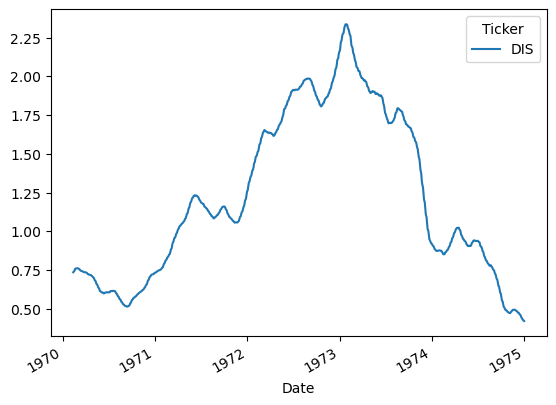

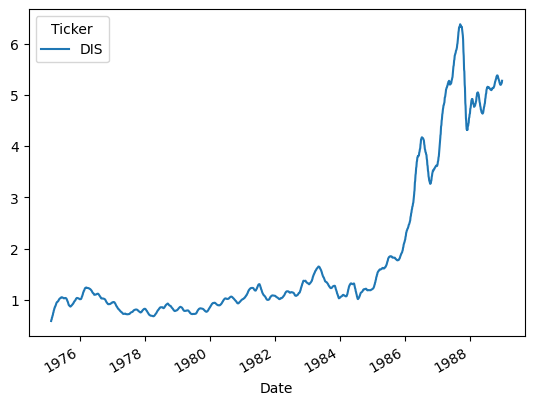

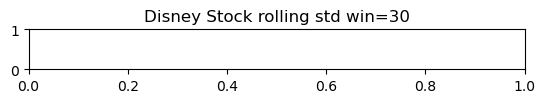

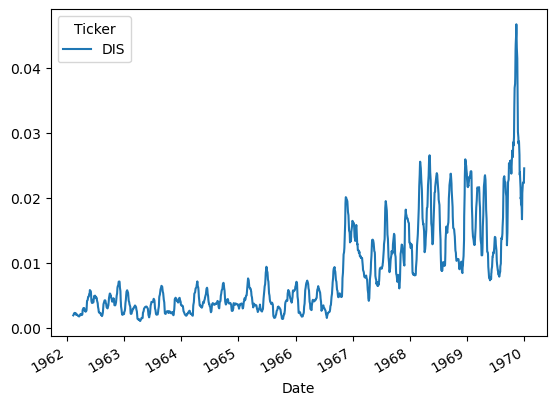

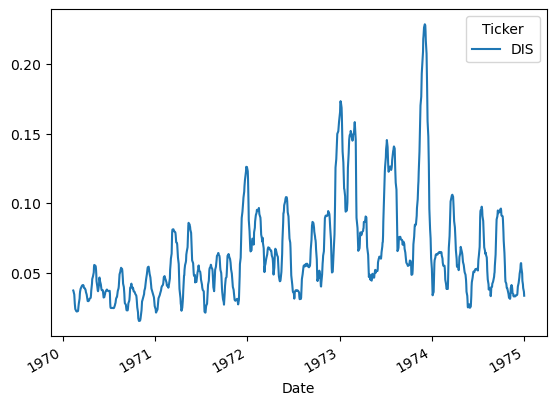

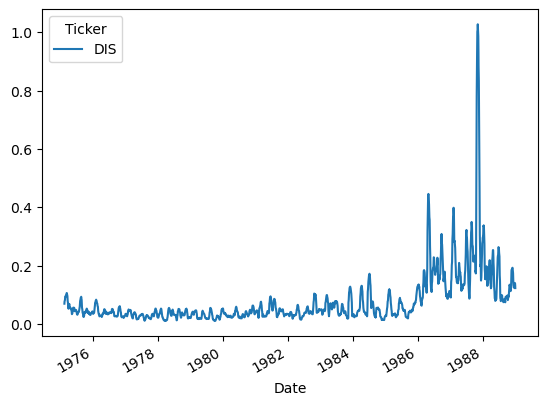

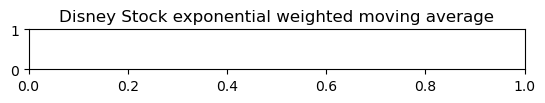

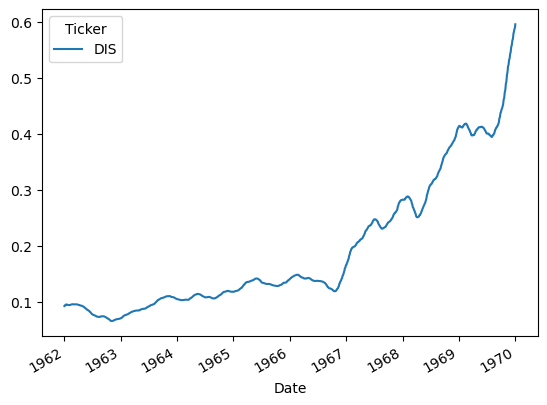

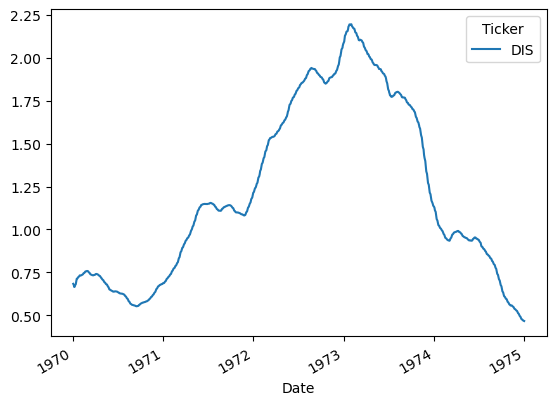

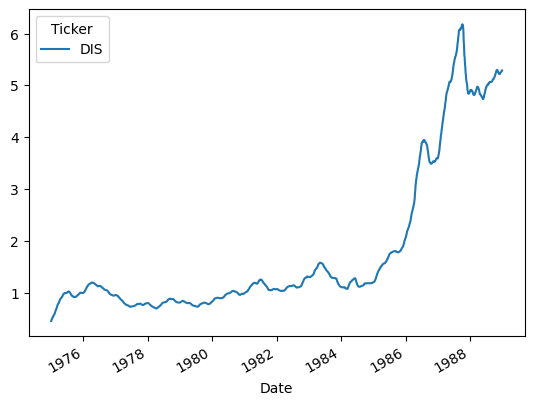

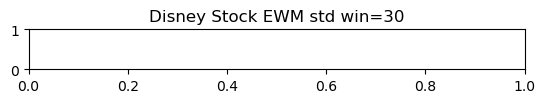

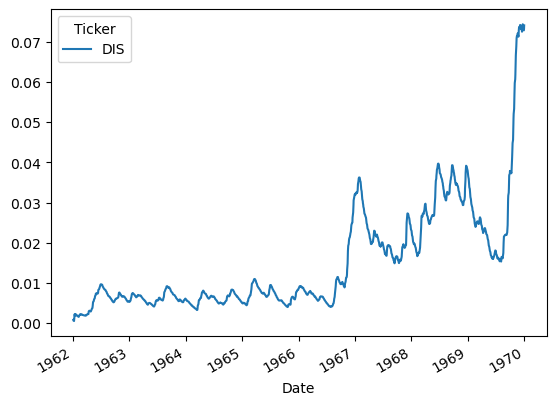

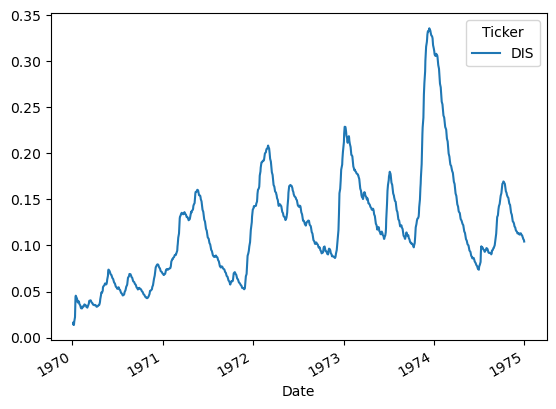

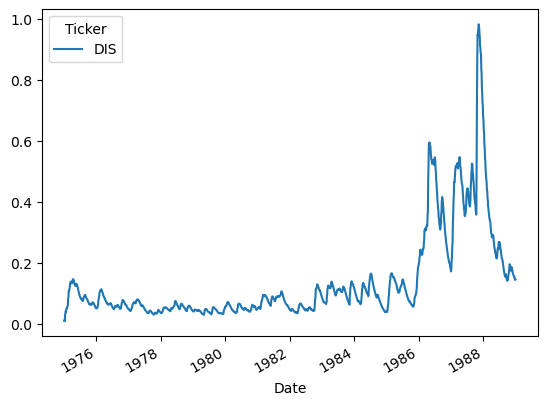

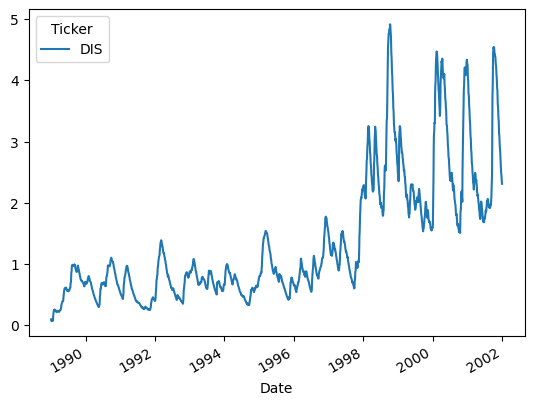

In [27]:
# very similar to 30 day window
# 20 days was a better representation of the full data set earlier, so we'll use the 20 day window
visPeriods(startup_close, growth_close, maturity_close, renewal_close, 'Disney Stock', 30)

C:\Users\Audrey\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


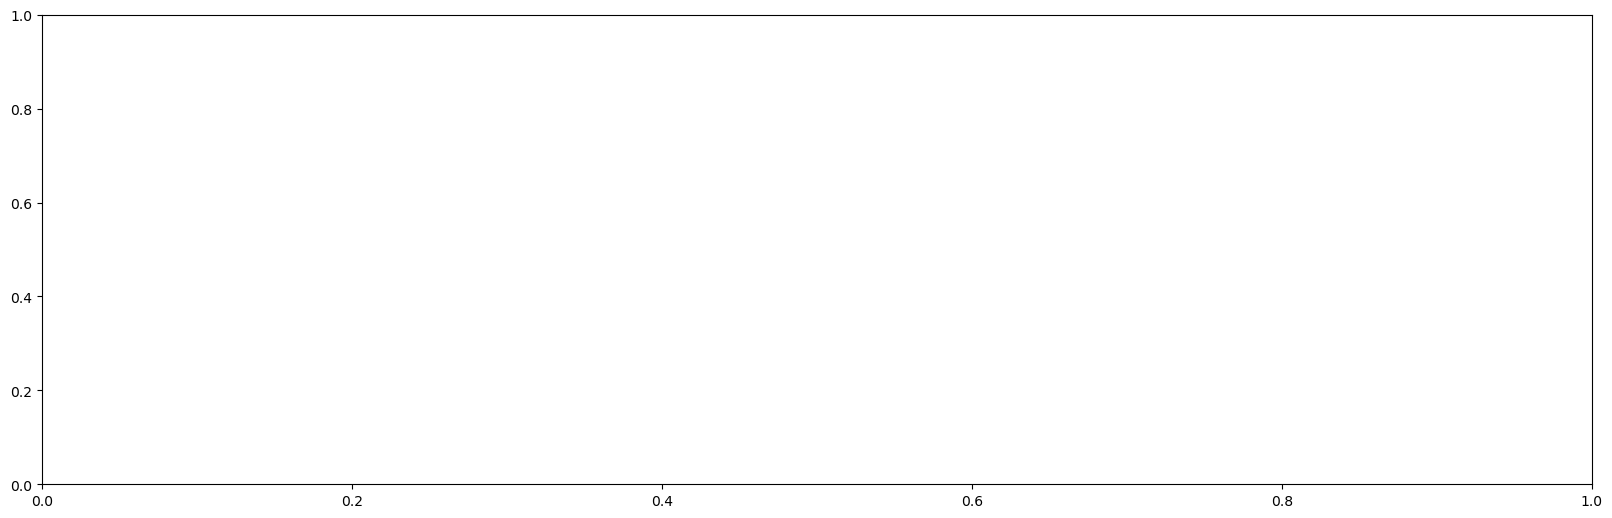

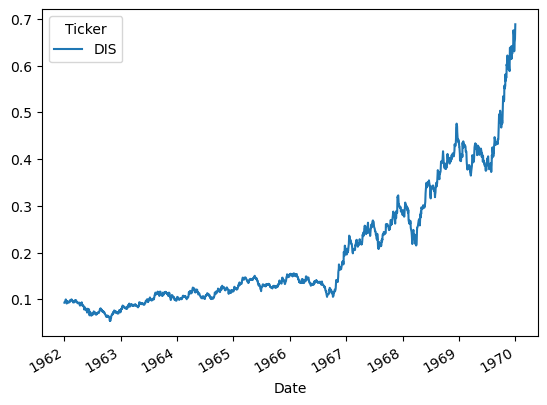

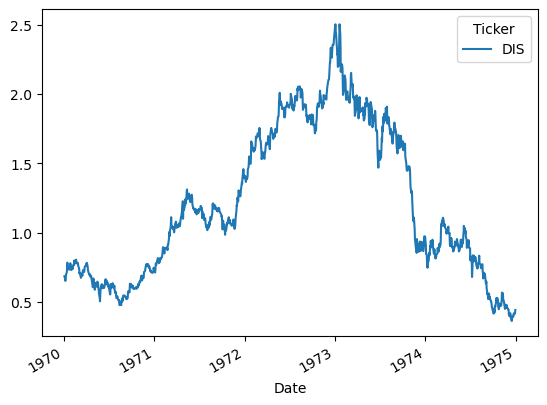

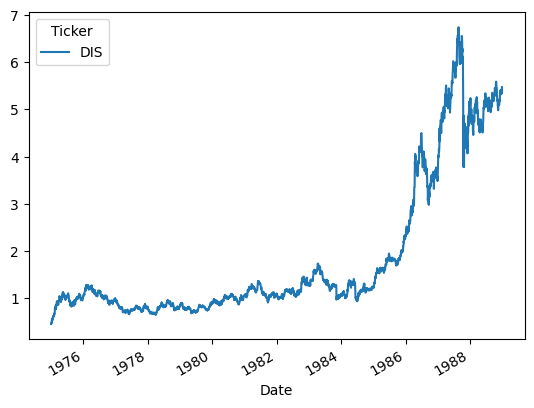

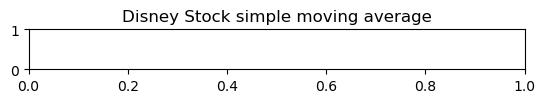

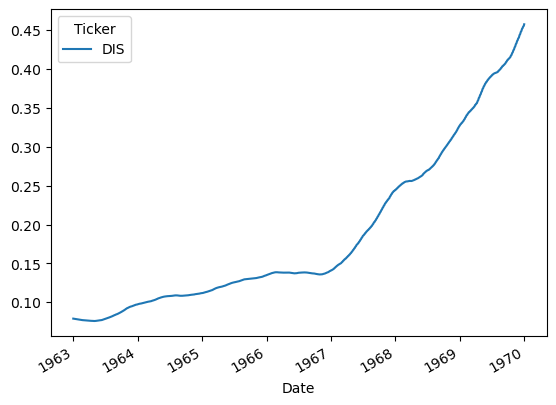

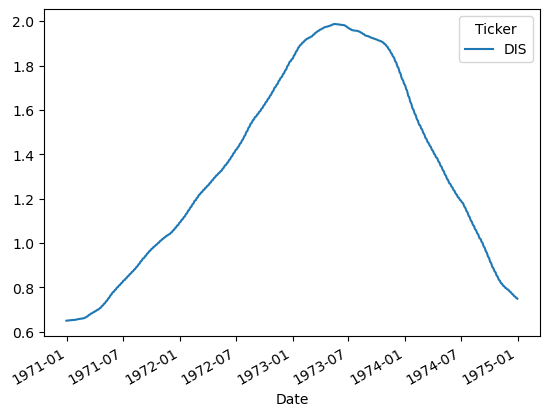

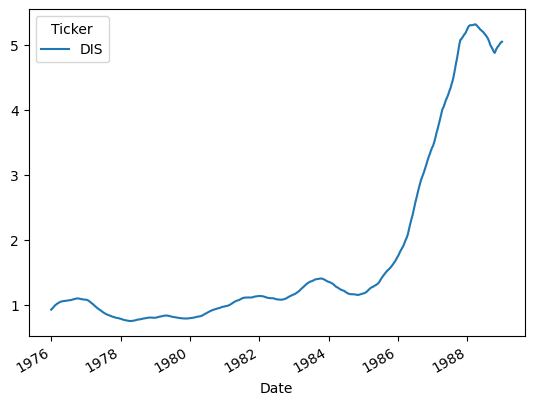

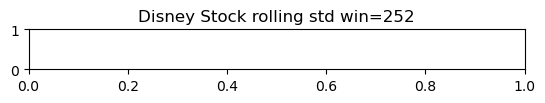

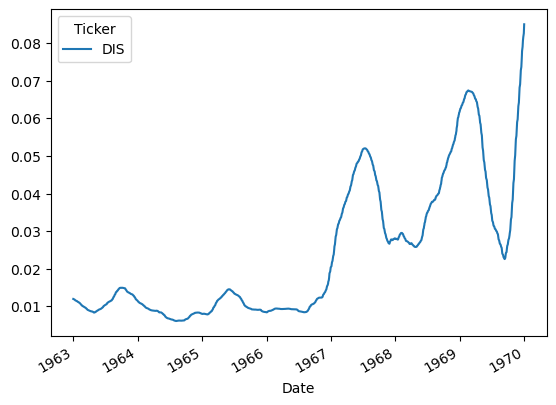

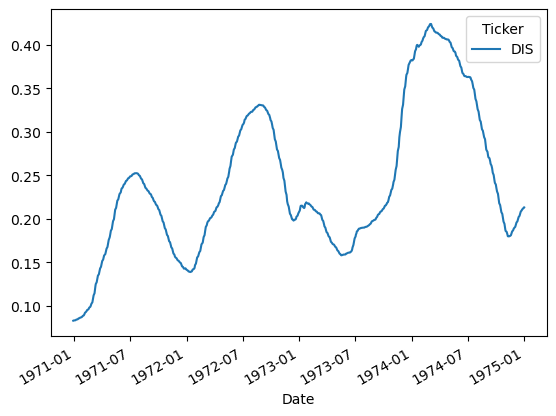

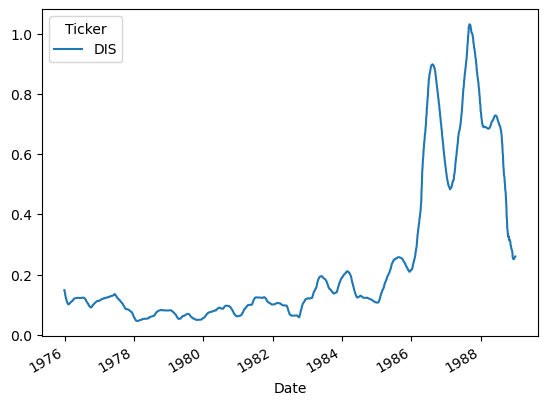

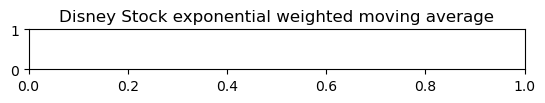

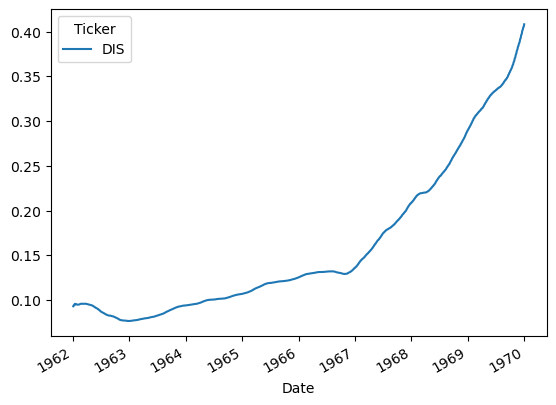

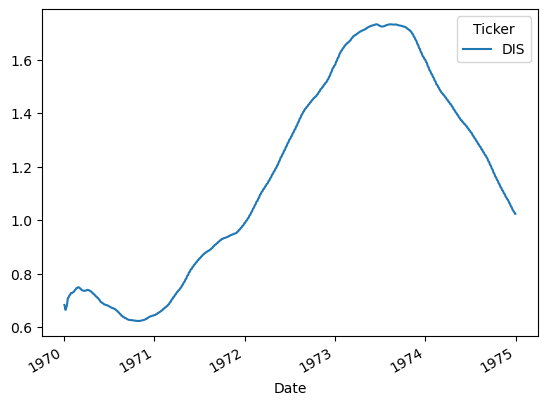

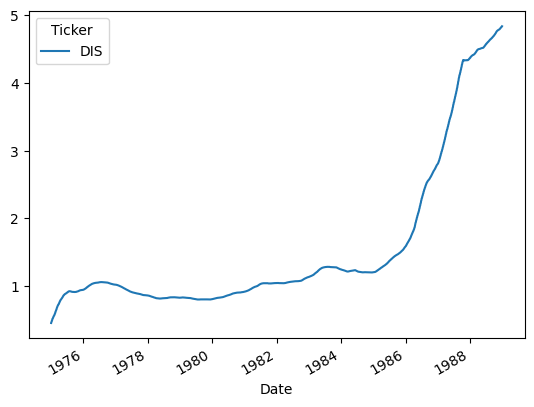

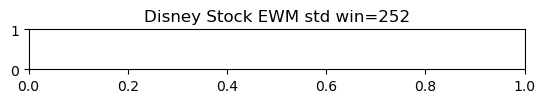

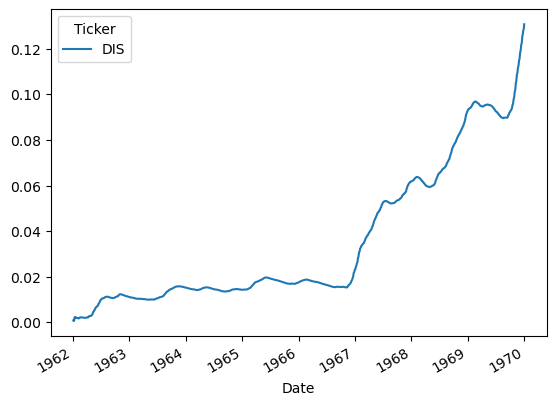

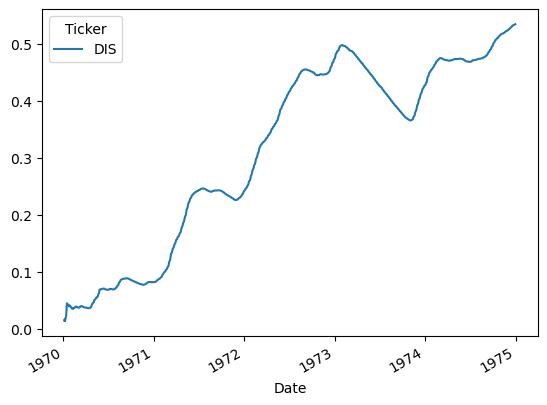

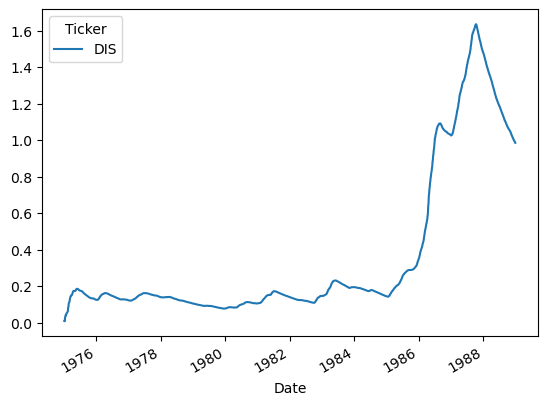

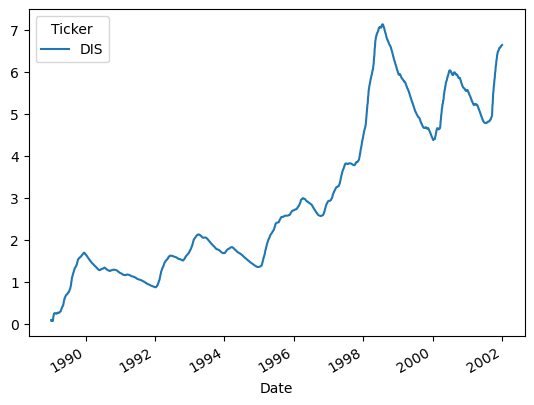

In [28]:
# all periods are very distinct in each visualization, so a year seems to be a good window size
visPeriods(startup_close, growth_close, maturity_close, renewal_close, 'Disney Stock', 252)

C:\Users\Audrey\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


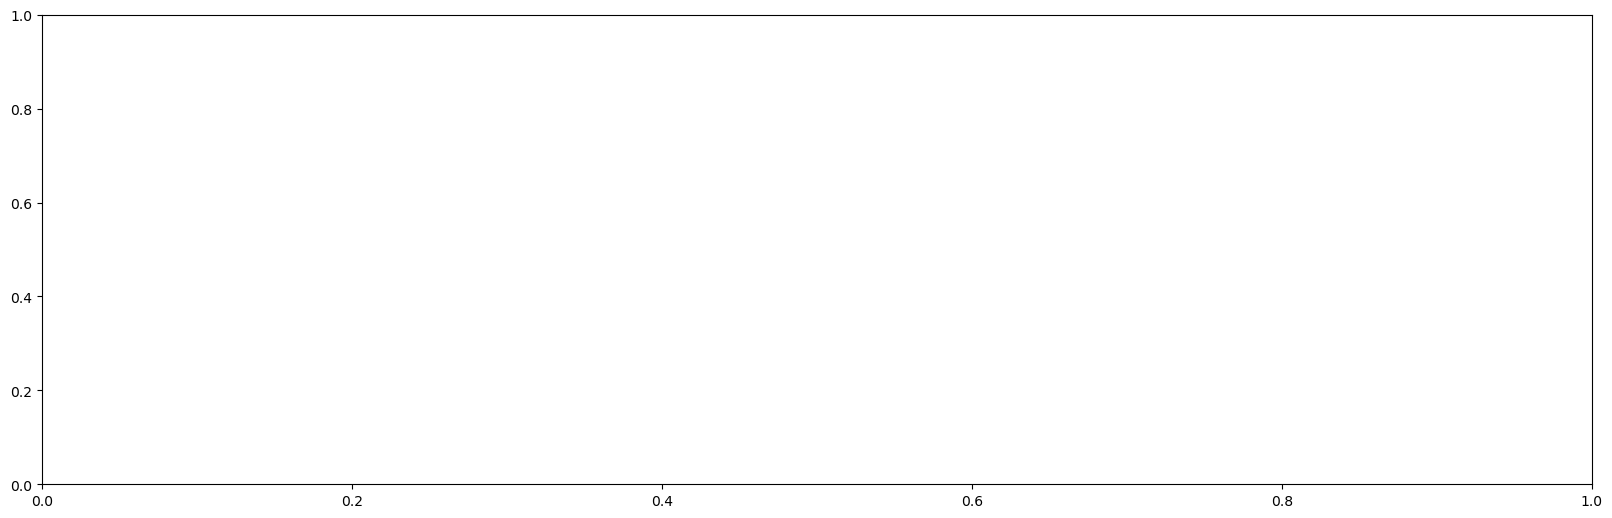

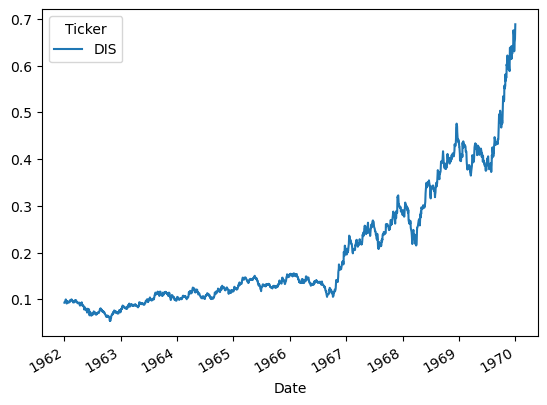

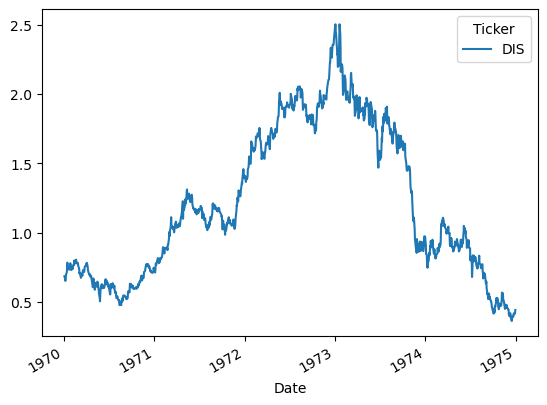

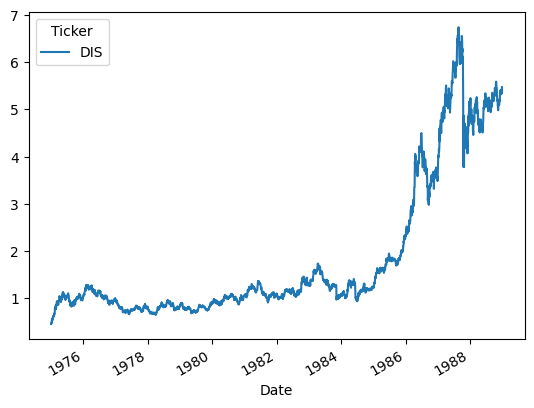

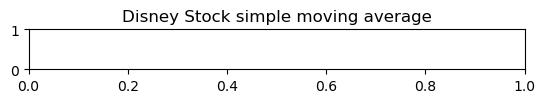

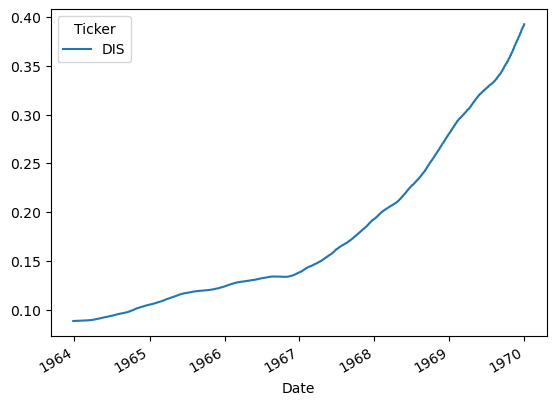

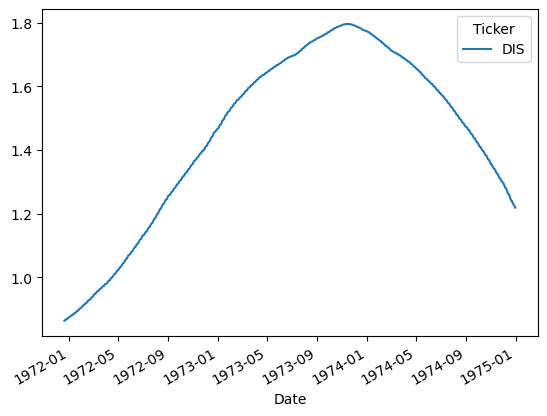

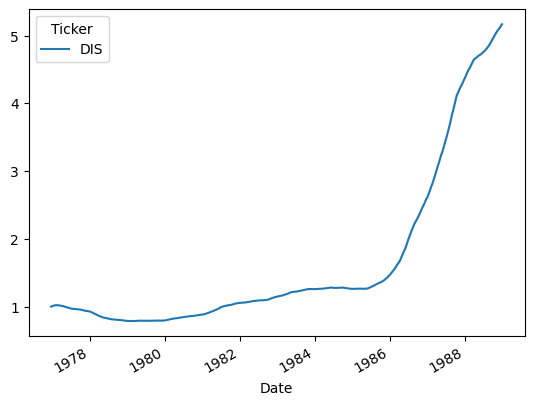

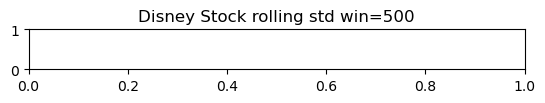

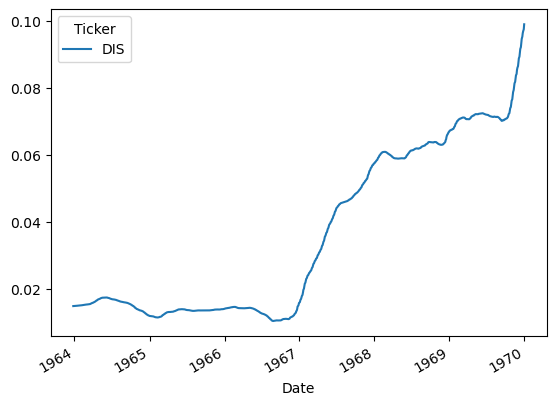

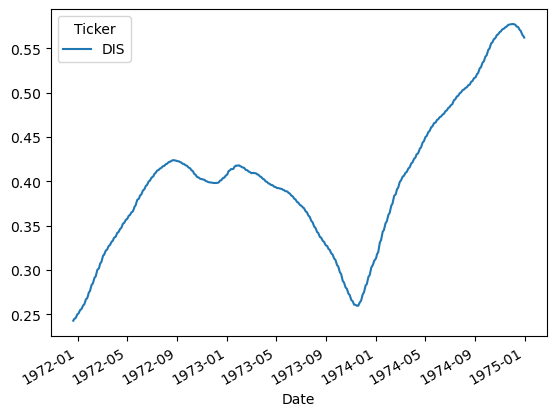

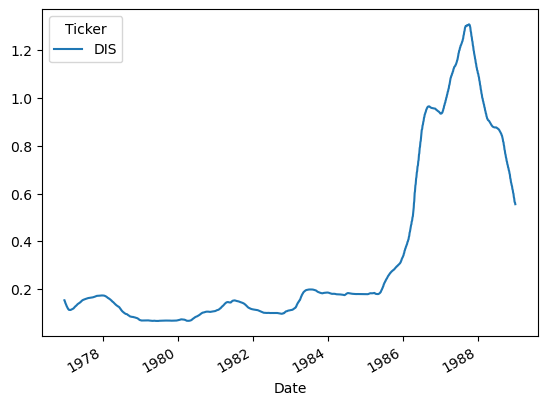

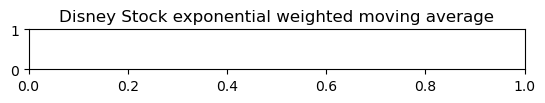

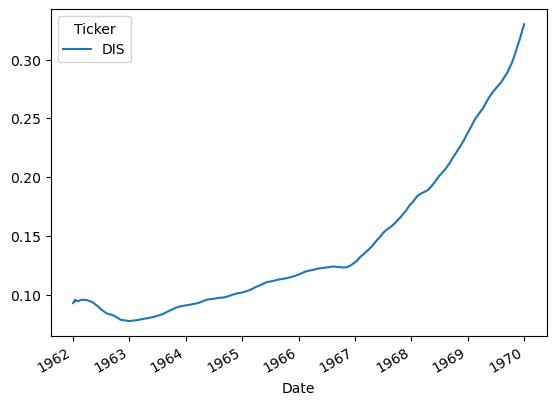

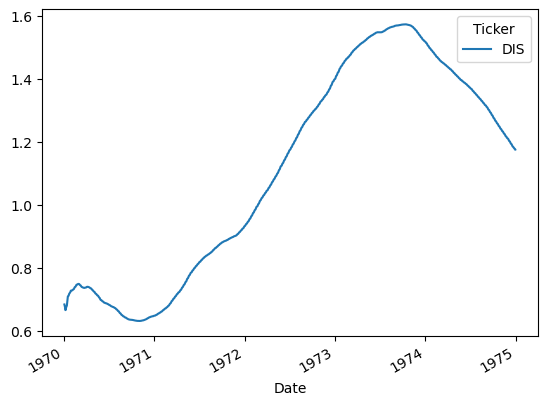

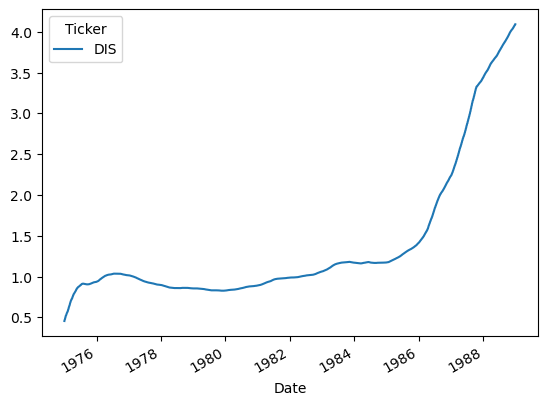

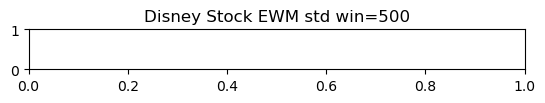

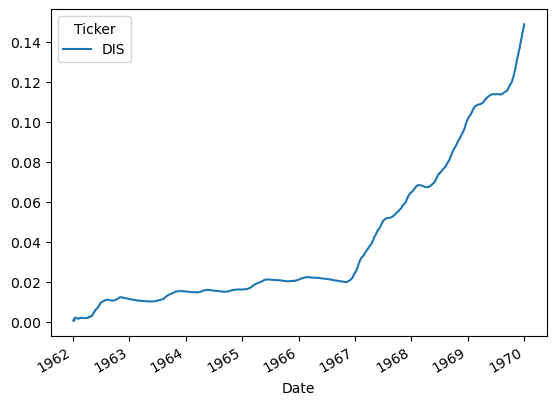

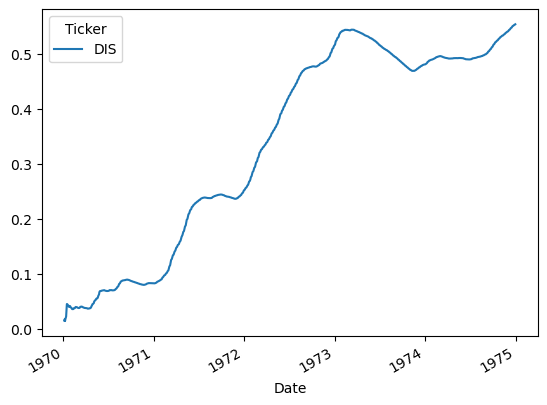

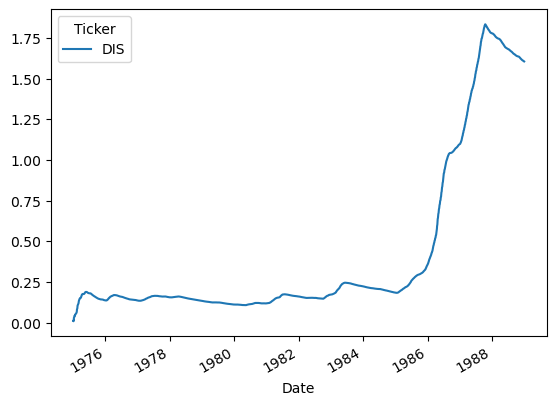

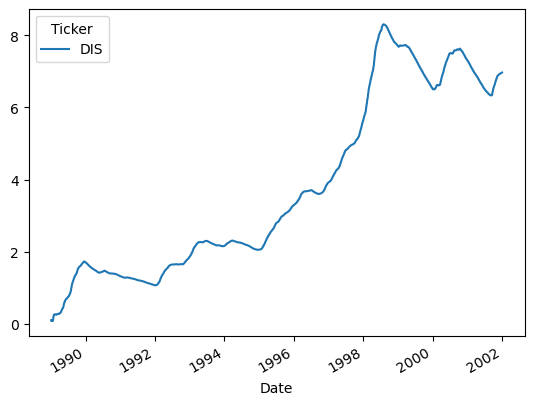

In [29]:
# SMA and EWMA growth period appears to be pretty flat, so might not be the best window size
visPeriods(startup_close, growth_close, maturity_close, renewal_close, 'Disney Stock', 500)

C:\Users\Audrey\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


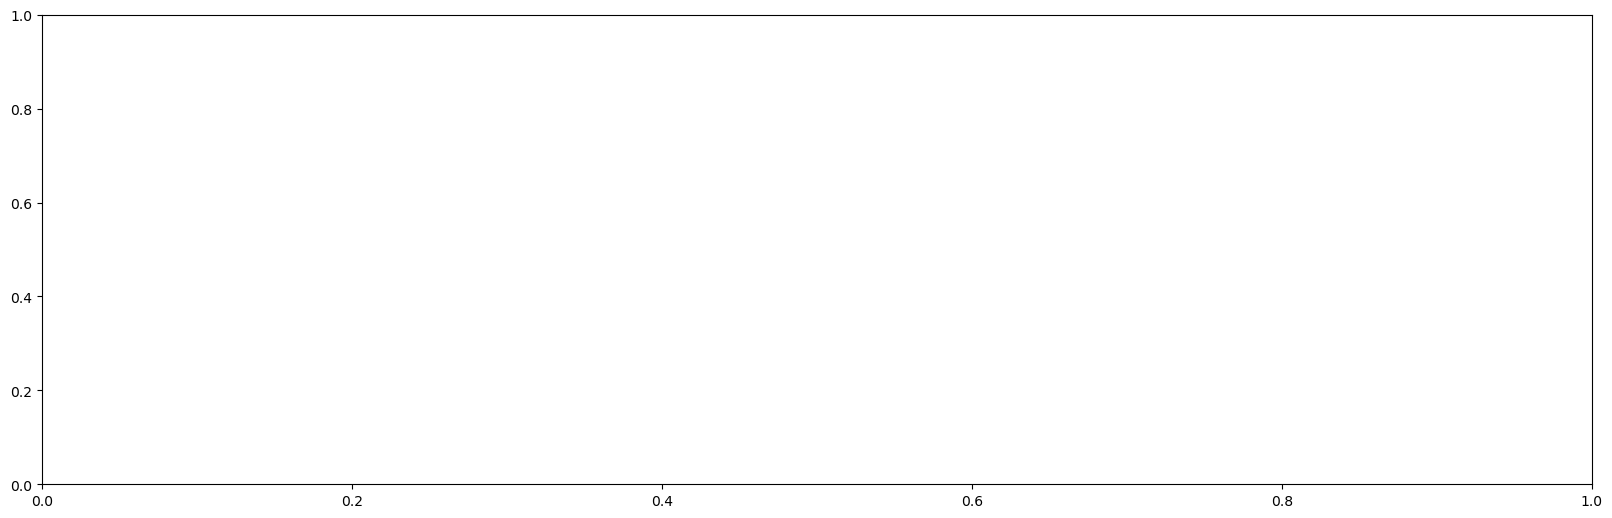

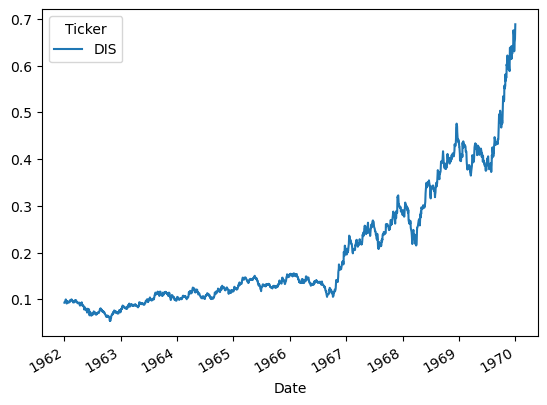

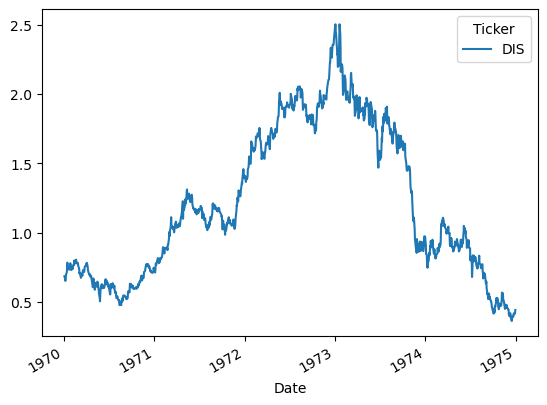

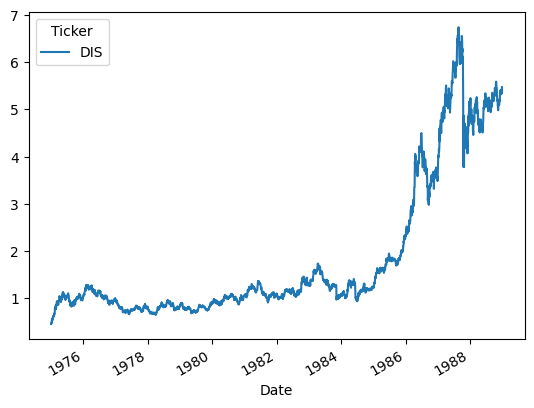

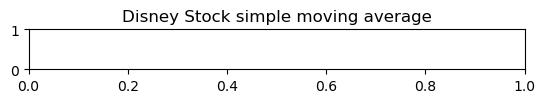

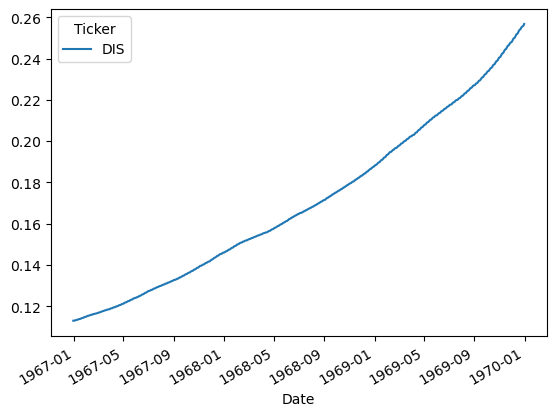

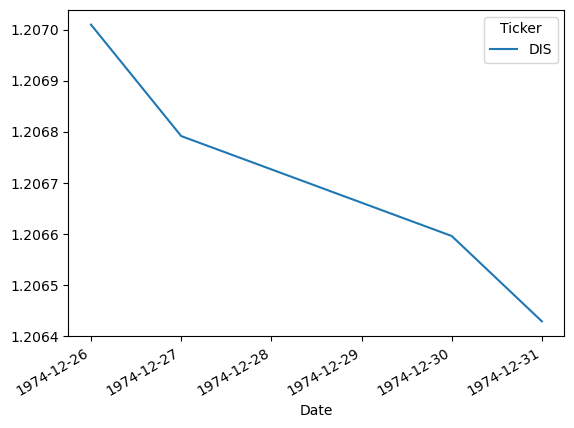

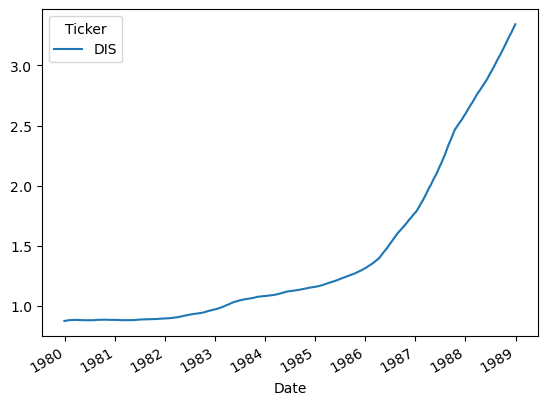

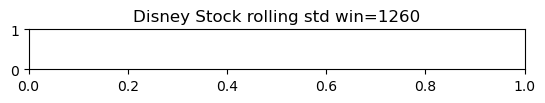

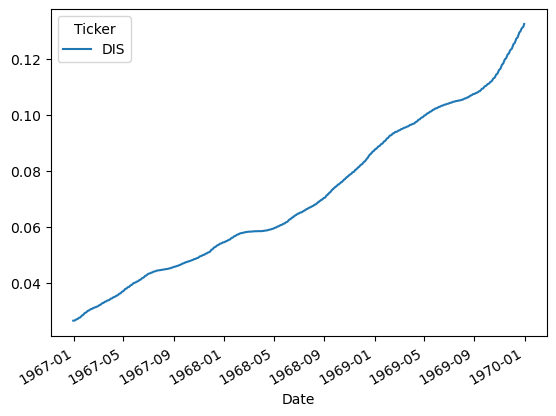

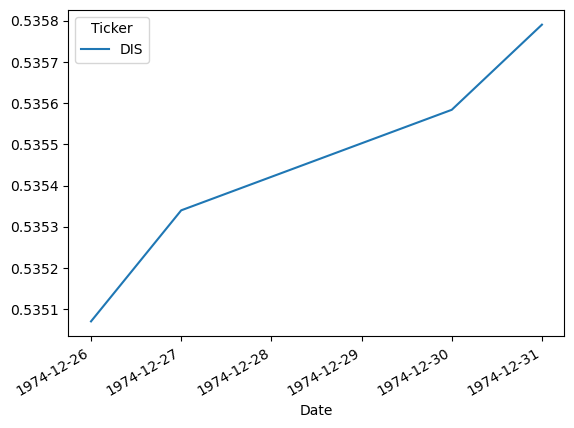

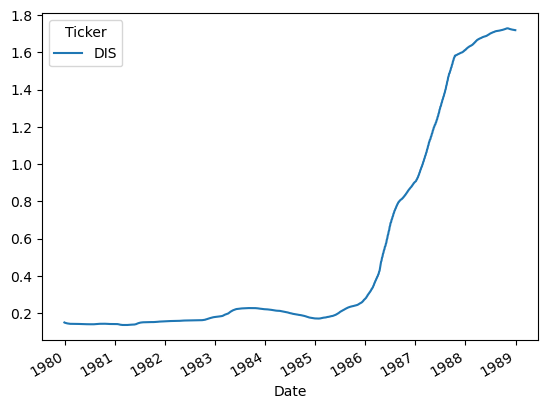

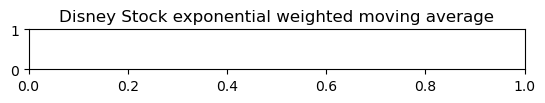

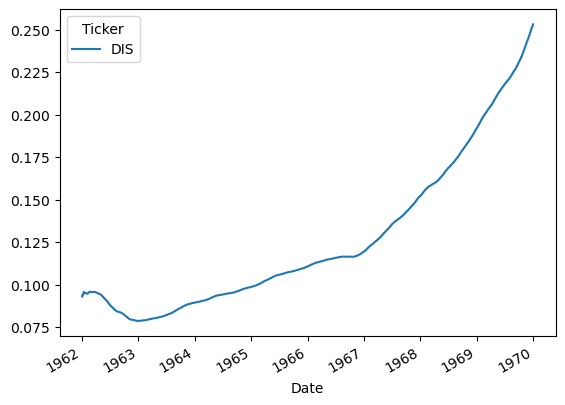

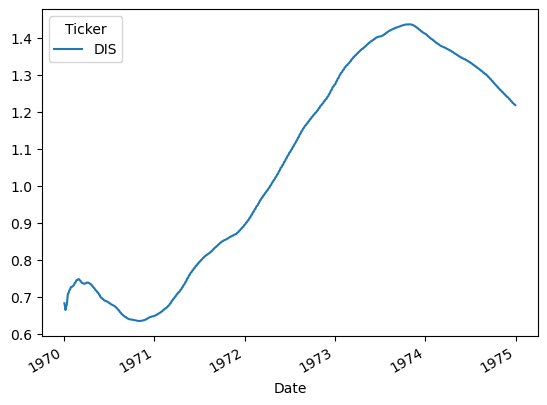

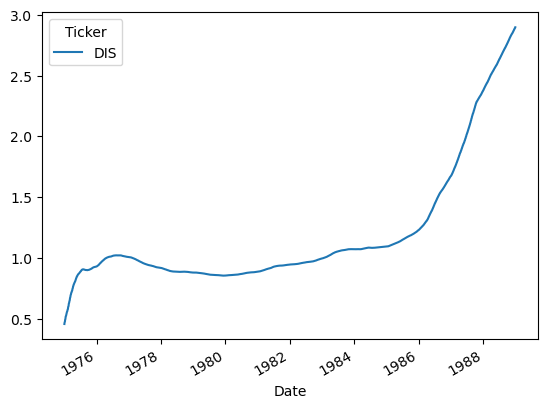

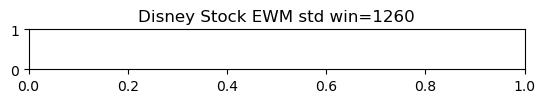

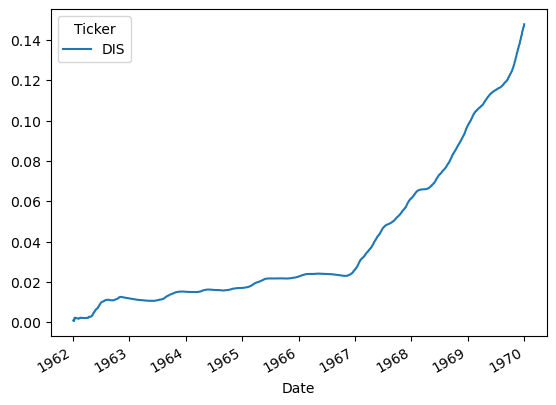

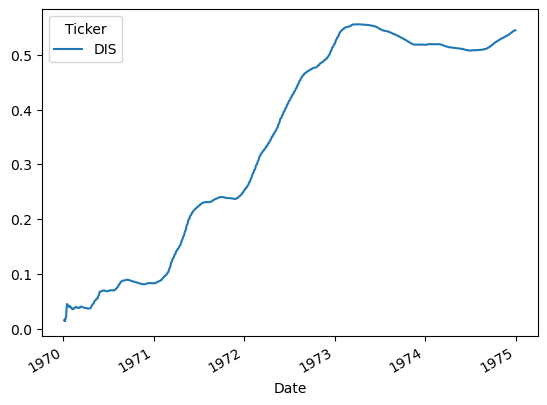

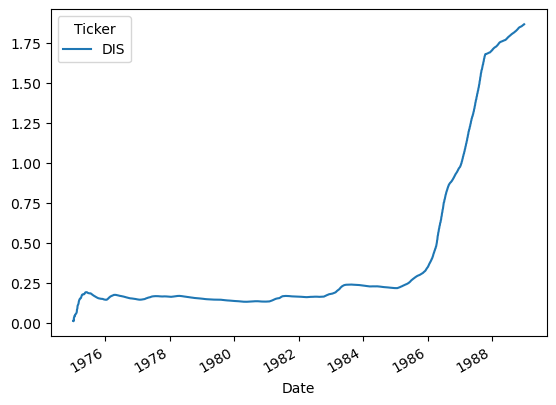

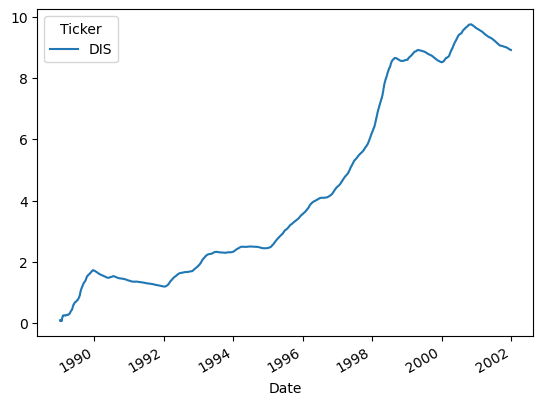

In [30]:
# not a good window size because growth period is nonexistent in SMA visualizations (since this period is 5 years)
visPeriods(startup_close, growth_close, maturity_close, renewal_close, 'Disney Stock', 1260)

In [31]:
# visTransformations(df_nvidia_close,'NVIDIA Stock',20)

In [32]:
df_dis_close.size

10069

<Figure size 3000x1000 with 0 Axes>

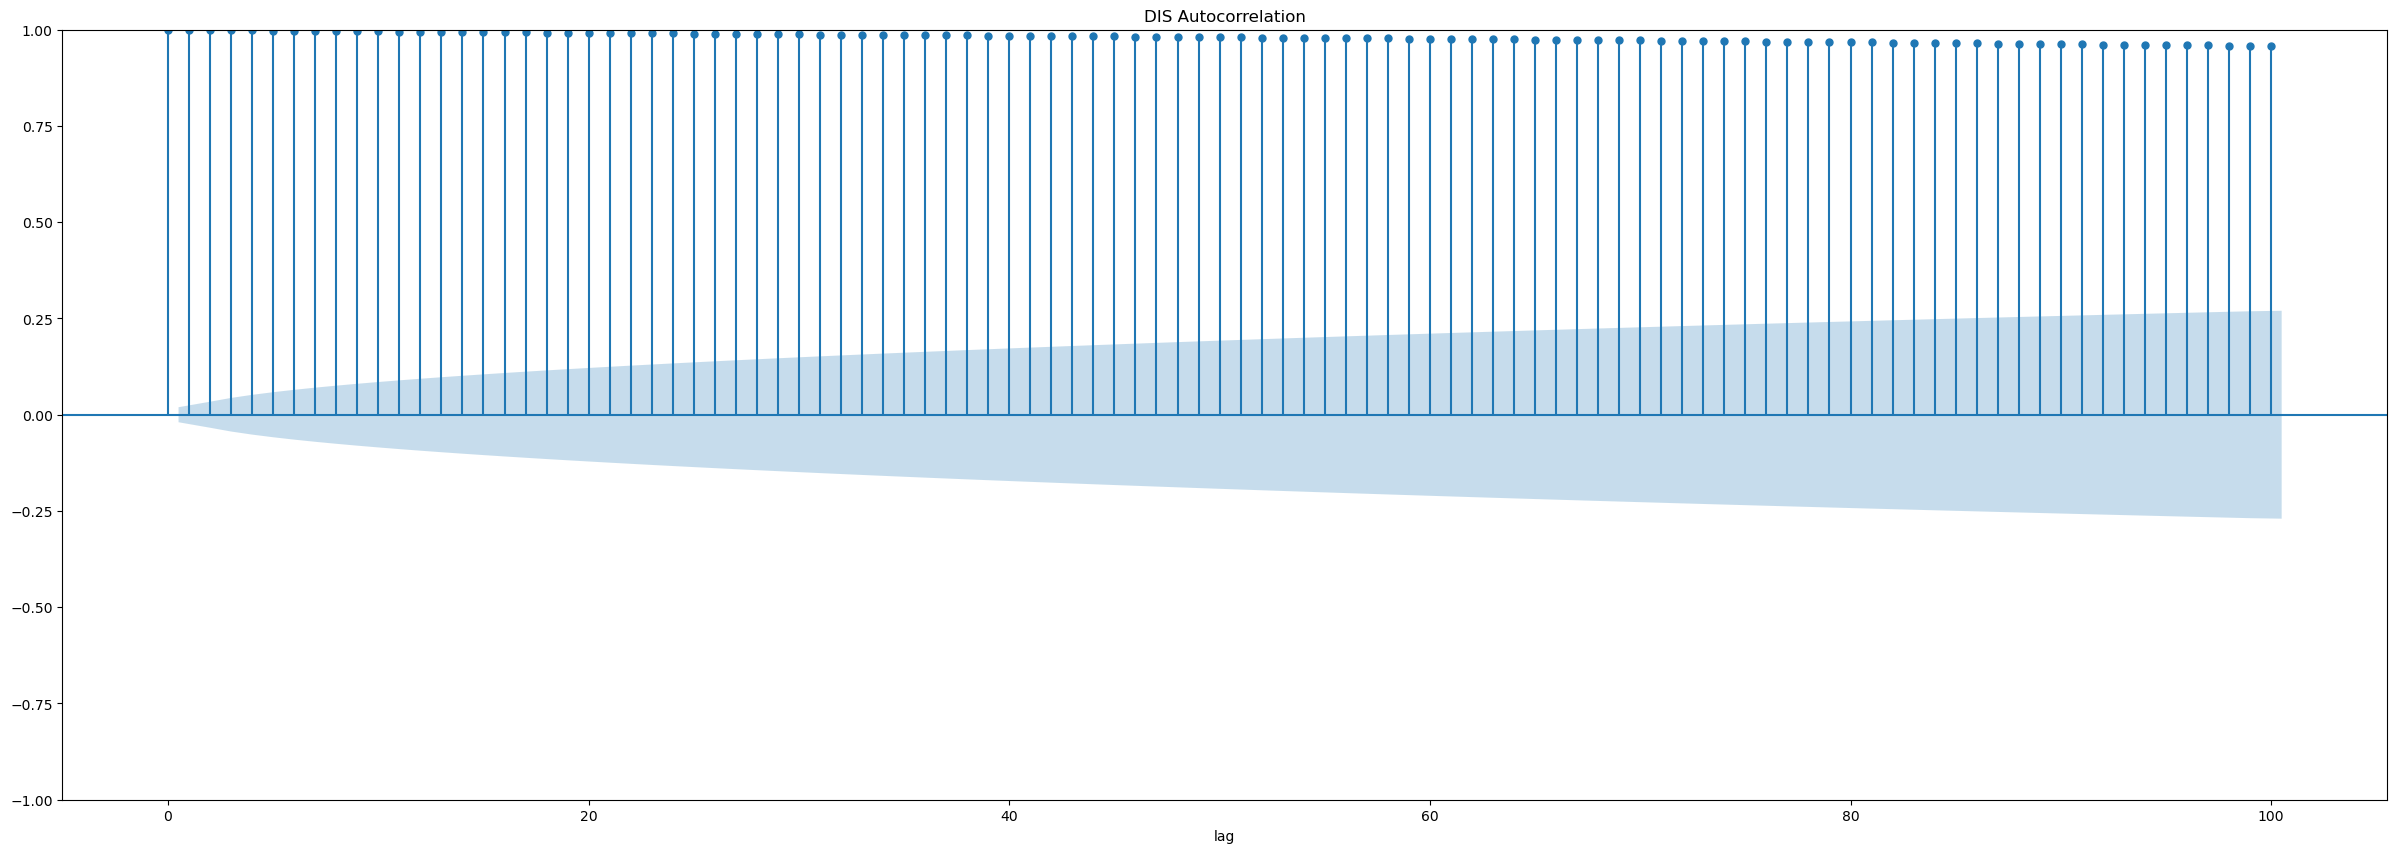

In [33]:
plt.figure(3,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_acf(df_dis_close, lags=100, title='DIS Autocorrelation',alpha=0.05,ax=ax);

C:\Users\Audrey\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 3000x1000 with 0 Axes>

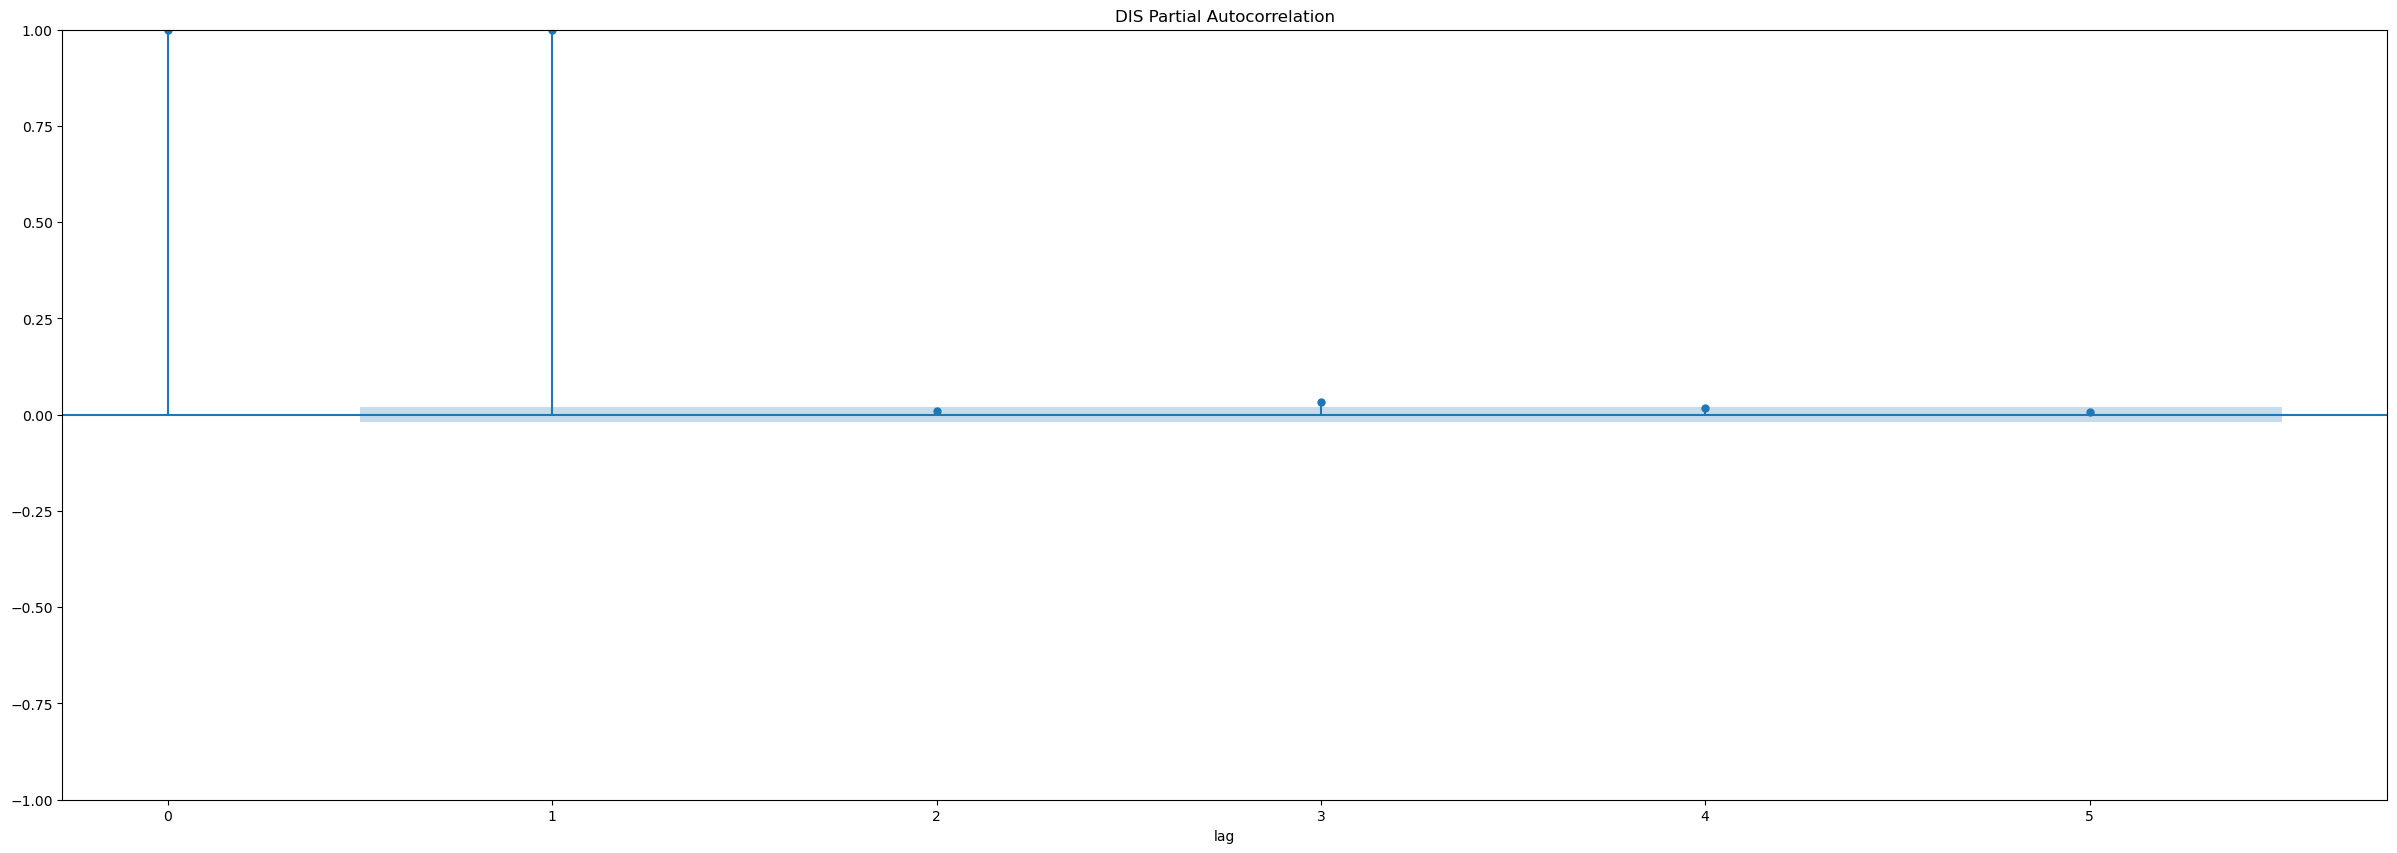

In [34]:
plt.figure(4,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_pacf(df_dis_close, lags=5, title='DIS Partial Autocorrelation',alpha=0.05,ax=ax);

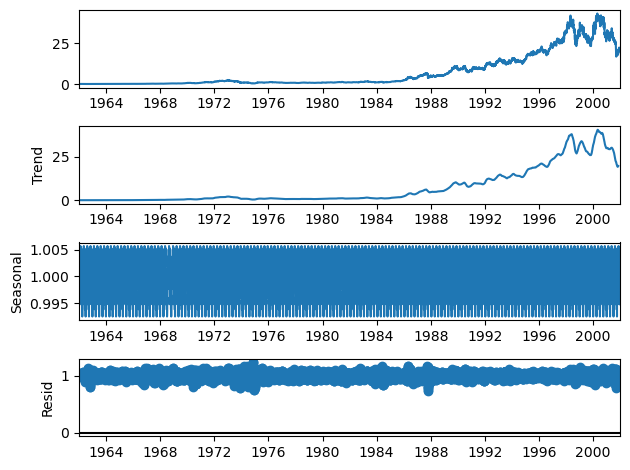

In [35]:
DAYS_PER_QUARTER= 63
result= seasonal_decompose(df_dis_close,model='multiplicative',period=DAYS_PER_QUARTER)
o= result.plot()

### ALGORITHMIC TRADING

In [102]:
### ALGORITHMIC TRADING

def generate_signals(data):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
# Create a short simple moving average over the short window
    signals['short_mavg'] = data['Close'].rolling(window=20, min_periods=1, center=False).mean()
# Create a long simple moving average over the long window
    signals['long_mavg'] = data['Close'].rolling(window=252, min_periods=1, center=False).mean()
# Create signals; where short term average is greater than long term avg, buy
    signals['signal'][20:] = np.where(signals['short_mavg'][20:] > signals['long_mavg'][20:], 1.0, 0.0)
# Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

# this generates whether to buy or sell

In [109]:
def backtest_strategy(signals, data, initial_capital=100000):
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    sharecol= pd.DataFrame(index=signals.index).fillna(0.0)
    positions['stock'] = 10 * signals['signal'] # Buy 10 shares on each buy signal
# Initialize the portfolio with value owned
    portfolio = positions.multiply(data['Adj Close']['DIS'], axis=0)
# Store the difference in shares owned
    pos_diff = positions.diff()
    # if signal == 0 and if there is actually stock to sell, sell it
    if (signals['signal'].item==0.0):
        if (pos_diff['signal']>0):
            # Sell all stock?
            positions['stock'] = int(pos_diff)* -1 * signals['signal']
    positions['stock'] = 10 * signals['signal'] # Buy 10 shares on each buy signal
# Add 'cash' to portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(data['Adj Close']['DIS'], axis=0)).cumsum()
# Add 'total' to portfolio
    portfolio['total'] = portfolio['cash'] + portfolio['stock']
    return portfolio

In [110]:
sig=generate_signals(disData)
port=backtest_strategy(sig, disData, initial_capital=100000)

In [111]:
sig

signal  short_mavg  long_mavg  positions
Date                                                
1962-01-02     0.0    0.092908   0.092908        NaN
1962-01-03     0.0    0.093532   0.093532        0.0
1962-01-04     0.0    0.093739   0.093739        0.0
1962-01-05     0.0    0.093921   0.093921        0.0
1962-01-08     0.0    0.093968   0.093968        0.0
...            ...         ...        ...        ...
2001-12-24     0.0   20.800352  26.212930        0.0
2001-12-26     0.0   20.777170  26.179557        0.0
2001-12-27     0.0   20.816136  26.155824        0.0
2001-12-28     0.0   20.850171  26.129449        0.0
2001-12-31     0.0   20.862502  26.107067        0.0

[10069 rows x 4 columns]

In [112]:
port

stock          cash         total
Date                                         
1962-01-02    0.0           NaN           NaN
1962-01-03    0.0  100000.00000  100000.00000
1962-01-04    0.0  100000.00000  100000.00000
1962-01-05    0.0  100000.00000  100000.00000
1962-01-08    0.0  100000.00000  100000.00000
...           ...           ...           ...
2001-12-24    0.0  100147.09762  100147.09762
2001-12-26    0.0  100147.09762  100147.09762
2001-12-27    0.0  100147.09762  100147.09762
2001-12-28    0.0  100147.09762  100147.09762
2001-12-31    0.0  100147.09762  100147.09762

[10069 rows x 3 columns]

In [113]:
####
# Run the augmented Dickey-Fuller Test
###
adfuller_test(df_dis_close)

(-0.9907597586227344, 0.7566195297032325, 39, 10029, {'1%': -3.431002206056025, '5%': -2.8618282363718994, '10%': -2.566923423081837}, 3292.141319897466)
ADF Test Statistic : -0.9907597586227344
p-value : 0.7566195297032325
#Lags Used : 39
Number of Observations : 10029
weak evidence against null hypothesis,indicating it is non-stationary 


In [39]:
#######
#  Tools are in place in Python to experiment with ARIMA and
#  propose the parameters (p,d,q)
####

DO_IT= False

if (DO_IT):
    stepwise_fit = auto_arima(df_dis_close, start_p = 1, start_q = 1, 
                              max_p = 3, max_q = 3, m = 12, 
                              start_P = 0, seasonal = True, 
                              d = None, D = 1, trace = True, 
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwis

    stepwise_fit.summary()

In [40]:
####### 
#  Fit the SARIMAX model
#
#  SARIMAX( nonseasonal, seasonal)
#
#  nonseasonaly= (p,d,q)
#
#  p: regression window size
#  d: differencing order
#  q: moving average (prediction error window)
#
#  seasonal=  (P,D,Q, m)
#
#  P: regression window size
#  D: differencing order
#  Q: moving average (prediction error window)
#
###
# MODEL IS NON-STATIONARY SO RUNNING ARIMA INSTEAD
#model = SARIMAX(df_dis_close,  
 #               order = (2,1,1),  
  #              seasonal_order =(4, 1, 1, 20)) 
  
#result = model.fit(disp=0) 
#result.summary() 

In [41]:
df_dis_close.size

10069

In [42]:
#######
# New index from Date Time
#
# Utility routine to fix issue with yfinance DateTime index
###
def computeDateList(startDate, numDays):
    dateList = []
    for x in range (0, numDays):
        dt= startDate + datetime.timedelta(days= x)
    
        dateList.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
        
    return dateList

In [43]:
origStartDate= datetime.datetime(2019,12,4)

forecastStartDate= datetime.datetime(2024,12,5)

HIST_DAYS= df_dis_close.size

NUM_DAYS= 252

disDateIndex= computeDateList(origStartDate,HIST_DAYS)

forecastDateIndex= computeDateList(forecastStartDate, NUM_DAYS)


In [44]:
#### DATA IS NON-STATIONARY SO NOT USING SARIMA
#######
# Use SARIMA model to do the forecast
# 
# Tinker with Series objects to properly set the index to good datetime format

  #  ONE_QUARTER= 63 * 1
  #  TWO_QUARTER= 63 * 2
  #  THREE_QUARTER= 63 *3
  #  FOUR_QUARTER= 64* 4

    #forecastHorizon= FOUR_QUARTER

    ####
    # do the forecast over time horizon (future days)
    ##
   # forecast= result.forecast(steps=forecastHorizon)

    #myForecast= pd.Series(forecast.values, index=forecastDateIndex)

    ####
    # do prediction over existing time series
    ##
  #  predictions= result.predict()

    ####
    # set Series index to proper datetime formatted strings
    ##
 #   myPredictions= pd.Series(predictions.values, index= disDateIndex)
#
#    myDISClose= pd.Series(df_dis_close.values, index= disDateIndex)

    ####
    # Visualize
    ###
 #   plt.figure(12,figsize=(20,15))
 #   plt.subplot(2,1,1)
 #   myDISClose.plot(color='blue',label='actual')
 #   myPredictions.plot(color='red',label='predictions')
 #   forecast.plot(color='green',label='forecast')
 #   plt.legend()
 #   plt.title(f'SARIMA forecast horizon= {forecastHorizon} steps')
#####

<Figure size 3000x1000 with 0 Axes>

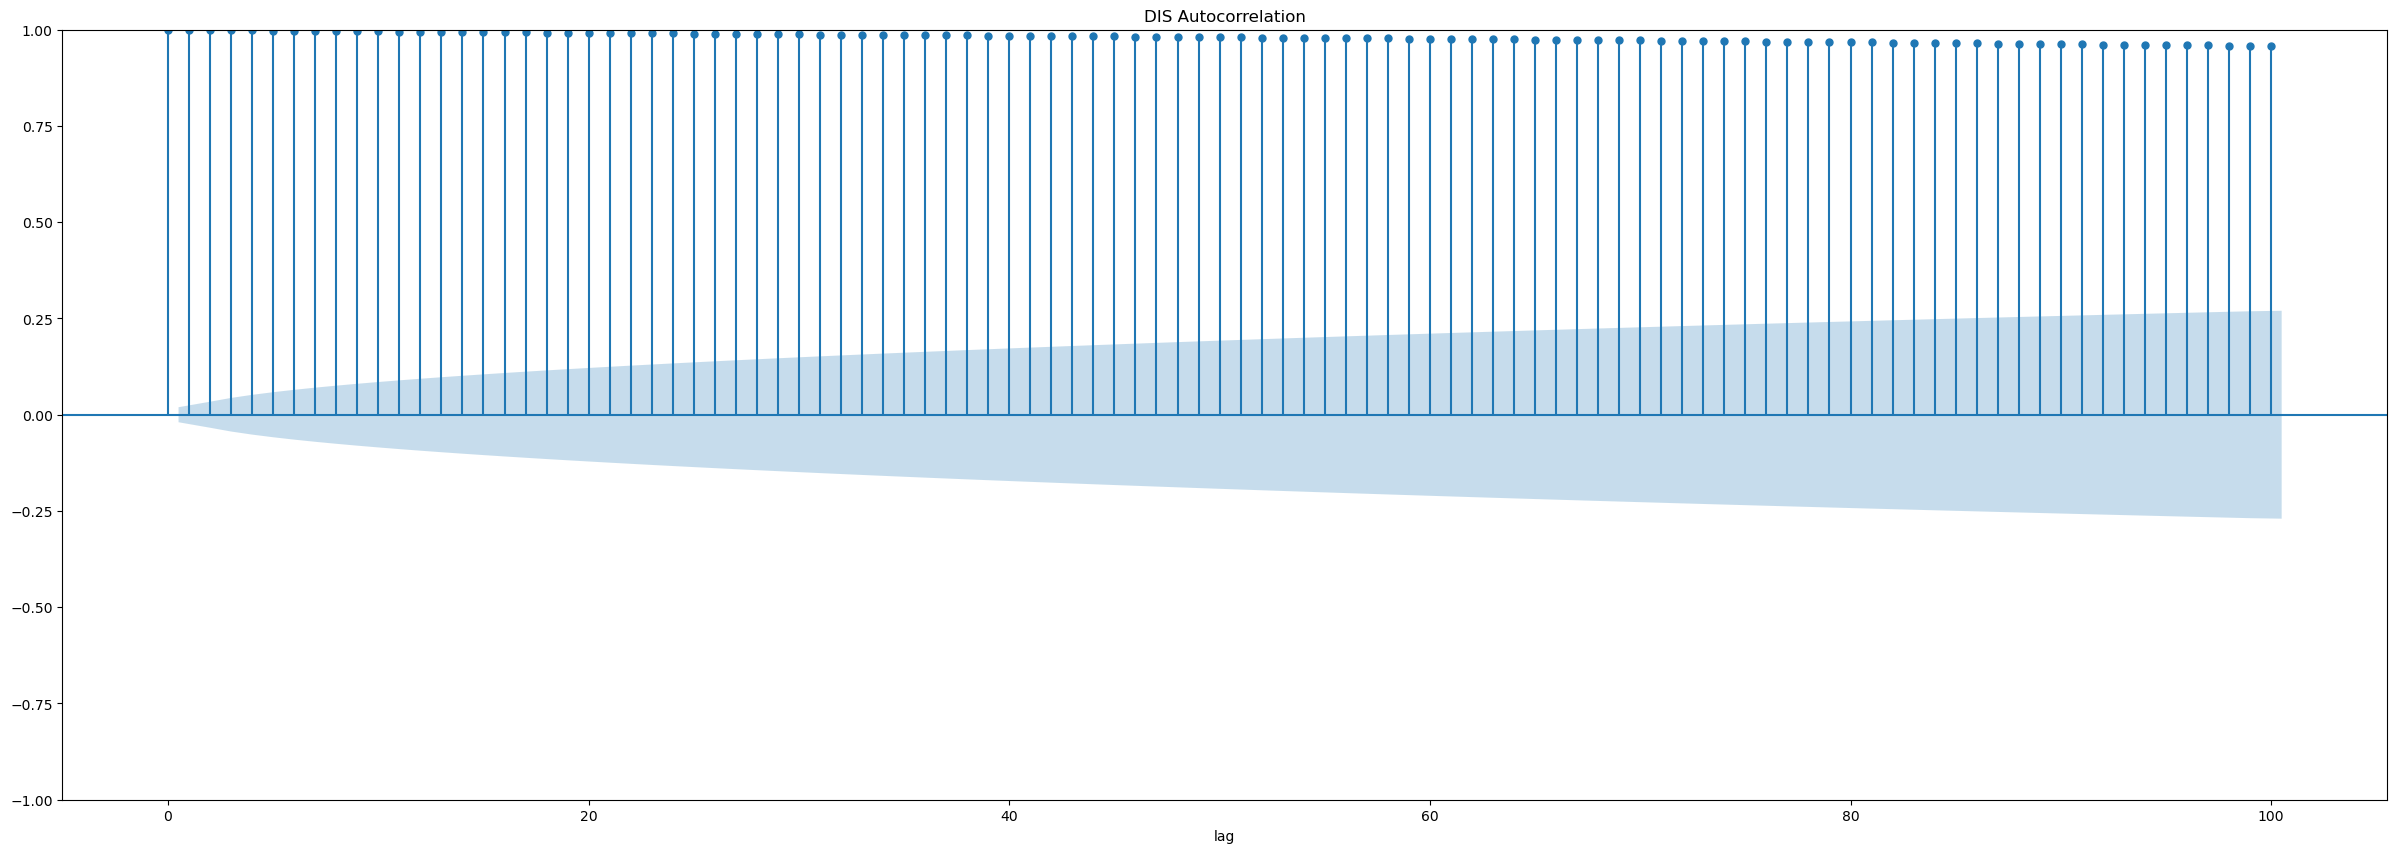

In [45]:
plt.figure(5,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_acf(df_dis_close, lags=100, title='DIS Autocorrelation',alpha=0.05,ax=ax);

C:\Users\Audrey\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 3000x1000 with 0 Axes>

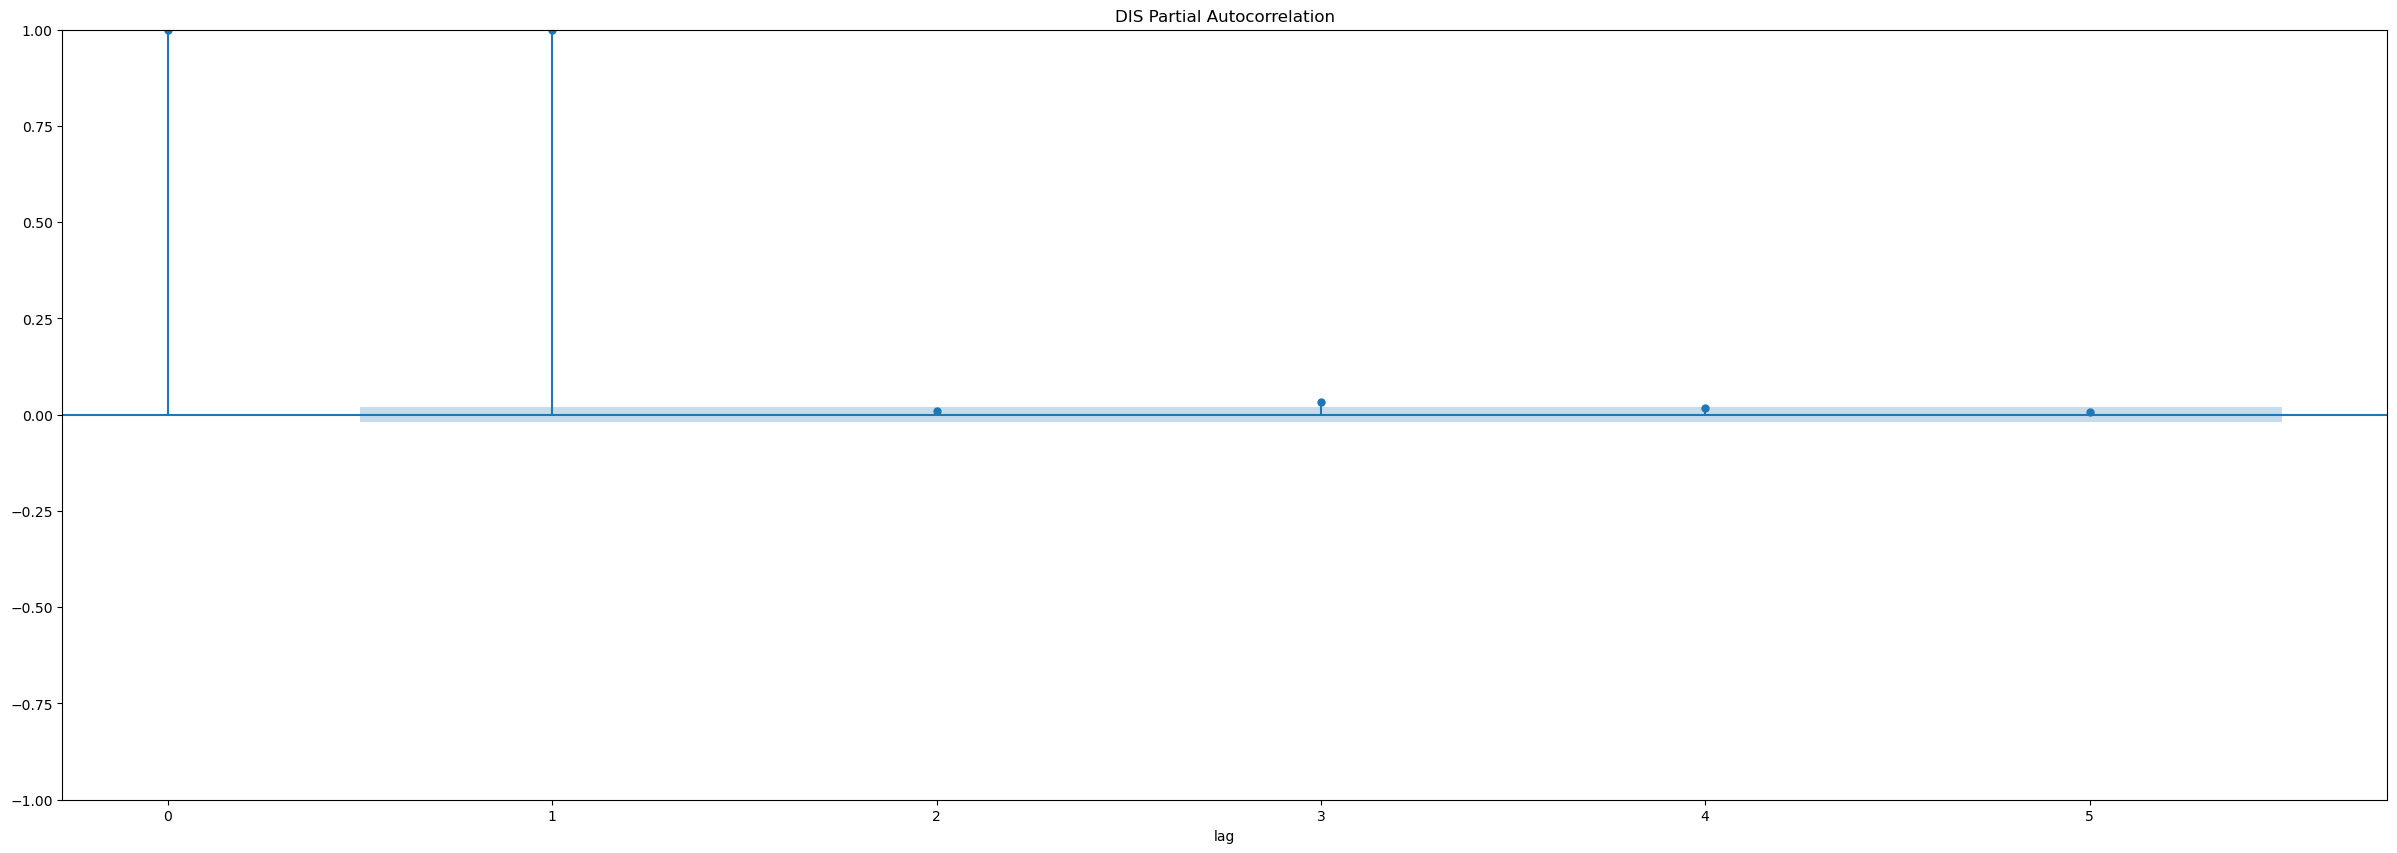

In [46]:
plt.figure(6,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_pacf(df_dis_close, lags=5, title='DIS Partial Autocorrelation',alpha=0.05,ax=ax);

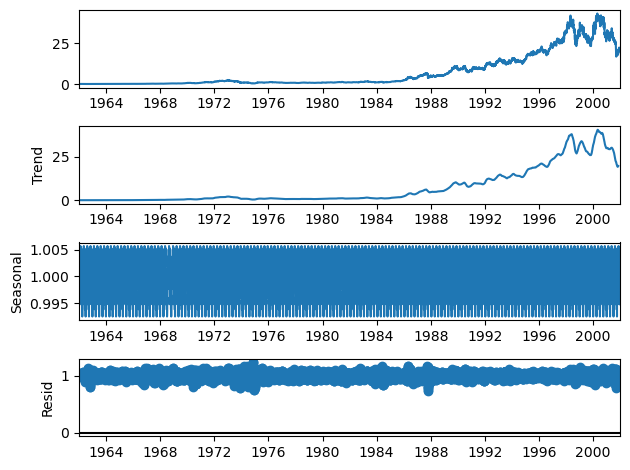

In [47]:
######
# Break time-series into it's constituent parts
#
# - level
# - trend
# - seasonality
# - noise
#
#  x(t) = Level + Trend + Seasonality + Noise
##
DAYS_PER_QUARTER= 63
result= seasonal_decompose(df_dis_close,model='multiplicative',period=DAYS_PER_QUARTER)
o= result.plot()

In [48]:
test_result=adfuller_test(df_dis_close)
test_result

(-0.9907597586227344, 0.7566195297032325, 39, 10029, {'1%': -3.431002206056025, '5%': -2.8618282363718994, '10%': -2.566923423081837}, 3292.141319897466)
ADF Test Statistic : -0.9907597586227344
p-value : 0.7566195297032325
#Lags Used : 39
Number of Observations : 10029
weak evidence against null hypothesis,indicating it is non-stationary 
